### Initial package imports

In [1]:
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from typing import Dict, List, Union
import random

## Initial files being read in and dataset creation

In [2]:
pd.set_option('display.float_format', '{:.6f}'.format)
# Read the data
main_df = pd.read_csv('Data/Cleaned_Indices_Assignment1.csv', sep=';')

# Read the interest rate data
#interest_rate_df = pd.read_csv('Data/ECB_Rates_2012_to_2022.csv', sep=';')
interest_rate_bond_df = pd.read_csv('Data/ECB_Data_10yr_Treasury_bond.csv', sep=',')

# Convert date columns to datetime format for proper merging
main_df['Date'] = pd.to_datetime(main_df['Date'], format='%d-%m-%Y')
#interest_rate_df['Date'] = pd.to_datetime(interest_rate_df['Date'], format='%d-%m-%Y')
#gov_bond_investment_df['Date'] = pd.to_datetime(gov_bond_investment_df['Date'], format='%Y-%m-%d')
interest_rate_bond_df['Date'] = pd.to_datetime(interest_rate_bond_df['Date'], format='%Y-%m-%d')

# Merge the dataframes on the Date column
main_df = pd.merge(main_df, interest_rate_bond_df, on='Date', how='left')
#main_df = pd.merge(main_df, gov_bond_investment_df, on='Date', how='left')

# Remove rows where the bond does not have a yield curve spot rate (Market closed?)
main_df = main_df.dropna(axis=0, subset=['Yield curve spot rate, 10-year maturity - Government bond'])

# Filter the dataframe to start from 2012-01-04
main_df = main_df[main_df['Date'] >= '2012-01-04']
main_df = main_df.reset_index(drop=True)

### government bond column

In [3]:
	
# Add a column for the interest bond value per day
days_per_annum = 365
interest_bond = 1500000

# Initialize the arrays with appropriate lengths matching the DataFrame
interest_bond_vector = np.zeros(len(main_df))
interest_bond_profit_vector = np.zeros(len(main_df))
interest_bond_loss_vector = np.zeros(len(main_df))
daily_rates = np.zeros(len(main_df))

# Set initial value
interest_bond_vector[0] = interest_bond


# Calculate bond values day by day based on the daily yield rate
for i in range(len(main_df)):
    # Adding 1.5% to account for the credit risk spread
    daily_rate = (((main_df['Yield curve spot rate, 10-year maturity - Government bond'].iloc[i] + 1.5) / (days_per_annum)) * (7/5)) / 100
    daily_rates[i] = daily_rate
    
    if i > 0:
        previous_value = interest_bond_vector[i-1]
        current_value = previous_value * (1 + daily_rate)
        interest_bond_vector[i] = current_value
        
        # Calculate change, profit/loss and return
        change = current_value - previous_value
        interest_bond_profit_vector[i] = change
        interest_bond_loss_vector[i] = -change

# Add vectors to the dataframe
main_df['Interest_Bond'] = interest_bond_vector
main_df['Interest_Bond_Profit'] = interest_bond_profit_vector
main_df['Interest_Bond_Loss'] = interest_bond_loss_vector
main_df['Interest_Bond_daily_rate'] = daily_rates




## Portfolio details

### details

#### Instruments:
- **S&P500**
- **DAX40**
- **NIKKEI**
- **EU Government Bond (10-year maturity, AAA-rated)**

#### Invested amount:
- **10,000,000 EURO**

#### Period:
- **01/01/2012 - 31/12/2022**

#### Weights:
- **S&P500**: 0.4  
- **DAX40**: 0.3  
- **NIKKEI**: 0.15  
- **EU Government Bond**: 0.15  

#### Measures:
- **Value at Risk (VaR)**: 1, 5, 10 days  
- **Expected Shortfall (ES)**  



### weights and currency correction


In [4]:
# initial investment 
weights = {
    'S&P500': 0.4,
    'DAX40': 0.3,
    'NIKKEI': 0.15,
    'EU-BOND': 0.15,
}

starting_investment = 10000000  # 10 million euros
starting_date = '2012-01-04'

# Filter the main_df for the starting date
starting_row = main_df[main_df['Date'] == starting_date]

# Extract the exchange rates for the starting date
usd_to_eur = float(starting_row['USD/EUR'].iloc[0])
jpy_to_eur = float(starting_row['JPY/EUR'].iloc[0])

# Calculate the invested amounts
invested_amount_SP500 = starting_investment * weights['S&P500'] / usd_to_eur
invested_amount_DAX40 = starting_investment * weights['DAX40']
invested_amount_NIKKEI = starting_investment * weights['NIKKEI'] / jpy_to_eur
invested_amount_EU_BOND = starting_investment * weights['EU-BOND']

invested_amounts = [
    invested_amount_SP500, #in USD
    invested_amount_DAX40, #in EUR
    invested_amount_NIKKEI, #in JPY
    invested_amount_EU_BOND #in EUR
]

print(invested_amounts)

[5177993.527508091, 3000000.0, 148957298.90764648, 1500000.0]


### Returns Portfolio 

In [5]:
# Create columns to track investments for each asset
# Initialize the first day with the initial invested amounts
main_df.loc[0, 'SP500_Investment'] = invested_amount_SP500
main_df.loc[0, 'DAX40_Investment'] = invested_amount_DAX40
main_df.loc[0, 'NIKKEI_Investment'] = invested_amount_NIKKEI
main_df.loc[0, 'EU_BOND_Investment'] = invested_amount_EU_BOND

# Calculate daily investment values for subsequent days
# This uses cumulative returns to track the value growth
for i in range(1, len(main_df)):
    # S&P 500 in USD
    main_df.loc[i, 'SP500_Investment'] = main_df.loc[i-1, 'SP500_Investment'] * (1 + main_df.loc[i, 'C_S&P500_Returns'])
    
    # DAX 40 in EUR
    main_df.loc[i, 'DAX40_Investment'] = main_df.loc[i-1, 'DAX40_Investment'] * (1 + main_df.loc[i, 'C_Dax40_Returns'])
    
    # NIKKEI in JPY
    main_df.loc[i, 'NIKKEI_Investment'] = main_df.loc[i-1, 'NIKKEI_Investment'] * (1 + main_df.loc[i, 'C_Nikkei_Returns'])
    
# EU Government Bond value is already calculated in the Interest_Bond column
main_df['EU_BOND_Investment'] = main_df['Interest_Bond']

# Methods input values 

### Portfolio change Daily

In [6]:
# Calculate total portfolio value in EUR for each day
main_df['Portfolio_Value_EUR'] = (
    main_df['SP500_Investment'].fillna(0) * main_df['USD/EUR'] +
    main_df['DAX40_Investment'].fillna(0) +
    main_df['NIKKEI_Investment'].fillna(0) * main_df['JPY/EUR'] +
    main_df['EU_BOND_Investment'].fillna(0)
)

# First day should be the initial investment amount
main_df.loc[0, 'Portfolio_Value_EUR'] = starting_investment

# Calculate the daily change in portfolio value (profit/loss)
main_df['Portfolio_Change_EUR'] = main_df['Portfolio_Value_EUR'].diff()
main_df.loc[0, 'Portfolio_Change_EUR'] = 0.0  # Set the first day's change to 0

# Portfolio loss is the negative of the daily change
main_df['Portfolio_loss'] = -main_df['Portfolio_Change_EUR']

# Set the first day's loss to 0 (there's no previous day to compare with)
main_df.loc[0, 'Portfolio_loss'] = 0.0

# Display the relevant columns to verify
display(main_df[['Date', 'SP500_Investment', 'DAX40_Investment', 'NIKKEI_Investment', 
                'EU_BOND_Investment', 'USD/EUR', 'JPY/EUR', 'Portfolio_Value_EUR', 
                'Portfolio_Change_EUR', 'Portfolio_loss']].head(20))

,Date,SP500_Investment,DAX40_Investment,NIKKEI_Investment,EU_BOND_Investment,USD/EUR,JPY/EUR,Portfolio_Value_EUR,Portfolio_Change_EUR,Portfolio_loss
0,2012-01-04,5177993.527508,3000000.000000,148957298.907646,1500000.000000,0.772500,0.010070,10000000.000000,0.000000,0.000000
1,2012-01-05,5189897.180583,2992352.262000,148944672.531480,1500246.523142,0.782100,0.010120,10058937.456095,58937.456095,-58937.456095
2,2012-01-06,5179533.786296,2973606.159562,148926948.770209,1500493.291886,0.786100,0.010210,10066275.107800,7337.651706,-7337.651706
3,2012-01-09,5188699.359796,2953565.582481,148926948.770209,1500738.323863,0.783300,0.010190,10036177.722841,-30097.384960,30097.384960
4,2012-01-10,5224622.209432,3024254.466714,148932709.395941,1500982.736072,0.782600,0.010190,10131650.852632,95473.129791,-95473.129791
5,2012-01-11,5225894.770664,3019028.766693,148937337.003152,1501223.999292,0.786900,0.010230,10156138.318562,24487.465930,-24487.465930
6,2012-01-12,5235403.197359,3032185.494802,148926138.139674,1501460.534432,0.779600,0.010160,10128255.925394,-27882.393168,27882.393168
7,2012-01-13,5214914.028114,3014404.192042,148946848.043152,1501695.498805,0.789000,0.010260,10158861.519952,30605.594558,-30605.594558
8,2012-01-16,5214914.028114,3051919.263087,148924774.146635,1501930.470054,0.789500,0.010280,10201971.036564,43109.516613,-43109.516613
9,2012-01-17,5229430.909452,3106827.837990,148940684.030302,1502166.395712,0.784900,0.010220,10235748.345320,33777.308756,-33777.308756


In [7]:
loss_values = main_df['Portfolio_loss'].values

# Calculate and print the minimum, maximum, and mean of portfolio loss values
min_loss = np.nanmin(loss_values)
max_loss = np.nanmax(loss_values)
mean_loss = np.nanmean(loss_values)

print(f"Portfolio Loss Statistics:")
print(f"Minimum Loss: {min_loss:.4f}")
print(f"Maximum Loss: {max_loss:.4f}")
print(f"Mean Loss: {mean_loss:.4f}")

# Also print the number of valid loss values (non-NaN)
valid_count = np.sum(~np.isnan(loss_values))
print(f"Number of valid loss values: {valid_count} out of {len(loss_values)}")

Portfolio Loss Statistics:
Minimum Loss: -850226.1294
Maximum Loss: 1342732.3440
Mean Loss: -3159.9673
Number of valid loss values: 2803 out of 2805


In [8]:
def calculate_daily_loss_variables(time_window, current_date):
    # Calculate the mean and standard deviation of portfolio loss from the time windows
    loss_dict = {
        "Date": current_date,
        "Portfolio_mean_loss": np.nanmean(time_window['Portfolio_loss']),
        "Portfolio_std_loss": np.nanstd(time_window['Portfolio_loss'])
    }
    return loss_dict

### Portfolio variance

## Value at Risk (VaR)

In [9]:
def VaR(alpha, r= 0, s= 1, df= 0):
    """
    Purpose:
        Get the VaR of the normal model

    Inputs:
        alpha   double, level
        r       double, expected return
        s       double, volatility
        df      (optional) double, degrees of freedom for student-t

    Return value:
        dVaR    double, VaR
    """
    if (df == 0):
        dVaR0= st.norm.ppf(alpha)
        dVaR = r + s*dVaR0
    else:
        dVaR0= st.t.ppf(alpha, df= df)

        dS2t= df/(df-2)

        c = s / np.sqrt(dS2t)
        dVaR= r + c*dVaR0
    return dVaR

## Expected Shortfall (ES) 

In [10]:
def ES(alpha, r= 0, s= 1, df= 0):
    """
    Purpose:
        Get the ES of the normal/student model

    Inputs:
        alpha   double, level
        r       double, expected return
        s       double, volatility
        df      (optional, default= 0/normal) double, df

    Return value:
        dES     double, ES
    """
    if (df == 0):
        dVaR0= st.norm.ppf(alpha)
        dES0= st.norm.pdf(dVaR0) / (1-alpha)
        dES= r + s*dES0
    else:
        dVaR0= st.t.ppf(alpha, df= df)
        dES0= st.t.pdf(dVaR0, df= df)*((df + dVaR0**2)/(df-1)) / (1-alpha)

        dS2t= df/(df-2)
        c= s / np.sqrt(dS2t)
        dES= r + c*dES0
    return dES

# performing different methods

write method for variance covariance where the sample period is an input parameter alongside other parameters that are needed for the calculation

## 1. var/cov multivar normal dist & T-distribution & Historical

4 code blocks with functions to calculate components of Var/cov method, 1 code block with for loop to iterate through set window for daily VaR and ES

### Main method

In [11]:
def calculate_var_cov(window, current_date, vAlpha, mean_loss, portfolio_std_loss, df=0):
    """
    Calculate Value at Risk using variance-covariance method.
    
    Parameters:
    - window: DataFrame containing the time window
    - current_date: Current date for reporting
    - vAlpha: Confidence levels (array)
    - mean_loss: Mean loss for the portfolio
    - portfolio_std_loss: Standard deviation of losses
    - df: Degrees of freedom for t-distribution (0 for normal distribution)
    
    Returns:
    - Dictionary with date, VaR and ES values
    """
    # Calculate VaR and ES
    var_result = VaR(vAlpha, mean_loss, portfolio_std_loss, df=df)
    es_result = ES(vAlpha, mean_loss, portfolio_std_loss, df=df)
    
    # Set label for distribution type
    if df == 0:
        dist_label = "Normal"
    else:
        dist_label = f"T{df}"
        
    return {
        'Date': current_date,
        f'VaR {dist_label}': var_result,
        f'ES {dist_label}': es_result
    }

def calculate_historical_var_es(window, current_date, vAlpha):
    """
    Calculate VaR and ES using historical simulation method.
    """
    # Extract portfolio loss values from the window
    historical_losses = window['Portfolio_loss'].dropna()
    
    # Sort losses in ascending order
    sorted_losses = np.sort(historical_losses)
    
    # Calculate VaR for alpha levels
    var_hist = np.percentile(sorted_losses, 100*vAlpha)
    
    # Calculate ES for each alpha level
    es_hist = []
    for i, alpha in enumerate(vAlpha):
        es_hist.append(sorted_losses[sorted_losses >= var_hist[i]].mean())
    
    return {
        'Date': current_date,
        'VaR Historical': var_hist,
        'ES Historical': es_hist
    }

def calculate_multiday_var(vAlpha, interval, sample_size):
    """
    Calculate multi-day VaR using the historical simulation method.
    
    Parameters:
    - vAlpha: Confidence levels (array)
    - interval: Number of days for the multi-day calculation (e.g., 5 or 10)
    
    Returns:
    - var_multi: VaR values at specified confidence levels
    """
    # Filter data for the period we want to analyze
    time_window_multi = main_df[(main_df['Date'] >= '2012-01-05') & (main_df['Date'] <= '2021-12-31')]
    # Create a new DataFrame for storing multi-day losses
    multi_day_losses = []
    
    # Calculate rolling sum of losses over the interval
    for i in range(sample_size, len(time_window_multi) - interval + 1, interval):
        window = time_window_multi.iloc[i:i+interval]
        if len(window) == interval:  # Ensure we have a complete window
            total_loss = window['Portfolio_loss'].sum()
            date = window['Date'].iloc[-1]
            daily_loss = window['Portfolio_loss'].iloc[-1]
            multi_day_losses.append({'Date': date, 'Portfolio_loss': total_loss, 'Daily_loss': daily_loss})

    # Convert to DataFrame
    multi_day_losses_df = pd.DataFrame(multi_day_losses)

    # Calculate VaR as percentiles of the multi-day losses for each row
    var_list = []
    for idx, row in multi_day_losses_df.iterrows():
        var_95 = np.percentile(multi_day_losses_df['Portfolio_loss'][:idx+1], vAlpha[0]*100)
        var_99 = np.percentile(multi_day_losses_df['Portfolio_loss'][:idx+1], vAlpha[1]*100)
        var_list.append([var_95, var_99])
    multi_day_losses_df[f'VaR_{interval}d_reg'] = var_list

    # calculate VaR per row using the square root of time rule for each alpha level
    sqrt_var_list = []
    for idx, row in multi_day_losses_df.iterrows():
        var_95 = np.percentile(multi_day_losses_df['Daily_loss'][:idx+1], vAlpha[0]*100) * np.sqrt(interval)
        var_99 = np.percentile(multi_day_losses_df['Daily_loss'][:idx+1], vAlpha[1]*100) * np.sqrt(interval)
        sqrt_var_list.append([var_95, var_99])
    multi_day_losses_df[f'VaR_{interval}d_sqrt'] = sqrt_var_list

    return multi_day_losses_df[['Date', 'Portfolio_loss', f'VaR_{interval}d_reg','Daily_loss', f'VaR_{interval}d_sqrt']]


In [12]:
def main():
    # Initialize lists to store results
    VaR_results = []
    ES_results = []
    # Define time window
    time_window = main_df[(main_df['Date'] >= '2012-01-05') & (main_df['Date'] <= '2021-12-31')]

    # Define confidence levels
    vAlpha = np.array([0.95, 0.99])
    
    # Define sample size and t-distribution degrees of freedom
    sample_size = 500
    degrees_of_freedom = [0, 3, 4, 5, 6]  # 0 represents normal distribution
    
    for i in range(sample_size, len(time_window)):
        # Extract the rolling window
        window = time_window.iloc[i - sample_size:i]
        current_date = time_window.iloc[i]['Date']
        
        # Calculate loss statistics
        loss_stats = calculate_daily_loss_variables(window, current_date)
        mean_loss = loss_stats["Portfolio_mean_loss"]
        portfolio_std_loss = loss_stats["Portfolio_std_loss"]
        
        # Initialize result dictionaries for this date
        var_row = {'Date': current_date}
        es_row = {'Date': current_date}

        
        # Calculate VaR and ES using various distributions
        for df in degrees_of_freedom:
            results = calculate_var_cov(window, current_date, vAlpha, mean_loss, portfolio_std_loss, df)
            
            # Get the distribution label
            if df == 0:
                dist_label = "Normal"
            else:
                dist_label = f"T{df}"
                
            # Add results to the dictionaries
            var_row[f'VaR {dist_label}'] = results[f'VaR {dist_label}']
            es_row[f'ES {dist_label}'] = results[f'ES {dist_label}']
        
        # Calculate VaR and ES using historical simulation
        hist_results = calculate_historical_var_es(window, current_date, vAlpha)
        var_row['VaR Historical'] = hist_results['VaR Historical']
        es_row['ES Historical'] = hist_results['ES Historical']
        
        # Add results for this date
        VaR_results.append(var_row)
        ES_results.append(es_row)

    # Convert results to DataFrame
    var_results_df = pd.DataFrame(VaR_results)
    es_results_df = pd.DataFrame(ES_results)

    var_5d = calculate_multiday_var(vAlpha, 5, sample_size)
    var_10d = calculate_multiday_var(vAlpha, 10, sample_size)

    return var_results_df, es_results_df, var_5d, var_10d

In [13]:
var_results_df, es_results_df, var_5d, var_10d = main()
print("VaR results")
display(var_results_df.head())
print("ES results")
display(es_results_df.head())
print("5-day VaR results")
display(var_5d.head())
print("10-day VaR results")
display(var_10d.head())

VaR results


,Date,VaR Normal,VaR T3,VaR T4,VaR T5,VaR T6,VaR Historical
0,2013-12-18,"[81302.63664499548, 116557.8206647567]","[66500.0619383496, 131830.6165469758]","[74194.10166977838, 133274.76638827572]","[76956.93327513001, 131048.81663183315]","[78289.0523017027, 128954.41013669476]","[76635.91909563044, 124145.53446132335]"
1,2013-12-19,"[81540.36535460044, 116948.85873262321]","[66673.420732097, 132288.06931669865]","[74400.91847336068, 133738.49913331453]","[77175.76442361444, 131502.86969604852]","[78513.67625254429, 129399.35554413183]","[76635.91909563044, 124145.53446132335]"
2,2013-12-20,"[81583.82100899826, 117072.39171649376]","[66683.25436225111, 132446.29236791207]","[74428.2280626306, 133900.0023734098]","[77209.34940706796, 131659.3169956632]","[78550.28696220386, 129551.04568579582]","[76635.91909563044, 124145.53446132335]"
3,2013-12-23,"[81449.94232613117, 116946.14283832564]","[66546.17215748523, 132323.34877527936]","[74292.81097526885, 133777.371318679]","[77074.53024214374, 131536.20420860325]","[78415.75608986102, 129427.47963454337]","[76635.91909563044, 124145.53446132335]"
4,2013-12-24,"[81344.25102681224, 116759.42425801957]","[66474.50173802942, 132101.52860189366]","[74203.45728066986, 133552.2320437702]","[76978.82670881803, 131316.18085242793]","[78316.99093636015, 129212.26987013622]","[76635.91909563044, 124145.53446132335]"


ES results


,Date,ES Normal,ES T3,ES T4,ES T5,ES T6,ES Historical
0,2013-12-18,"[102919.40357702052, 134088.11596528185]","[111925.79978603563, 205375.94545968543]","[113372.33433465094, 187180.66054295484]","[112022.79044542332, 174626.61934549522]","[110710.06108526267, 166541.30891156162]","[111708.34439938828, 164482.19009839074]"
1,2013-12-19,"[103251.13414076928, 134555.38561149305]","[112296.69522330425, 206153.21466186325]","[113749.52011728345, 187878.80641812333]","[112394.10765260074, 175270.1731924816]","[111075.66980725207, 167149.70328375197]","[111708.34439938828, 164482.19009839074]"
2,2013-12-20,"[103343.68932523283, 134718.73626392966]","[112409.7072051621, 206478.48587062483]","[113865.81770455973, 188162.74952534074]","[112507.33993547823, 175525.601511842]","[111185.92040489928, 167386.76692610077]","[111708.34439938828, 164482.19009839074]"
3,2013-12-23,"[103214.48886812176, 134596.2812314945]","[112282.45588109421, 206371.45870310027]","[113738.87943448385, 188051.78459733597]","[112380.10960179259, 175411.91968176496]","[111058.40597487664, 167271.3353011707]","[111708.34439938828, 164482.19009839074]"
4,2013-12-24,"[103059.1155745959, 134369.2726285266]","[112106.38311267976, 205980.6086920669]","[113559.48208375371, 187702.75296009865]","[112203.81391894358, 175091.74110123166]","[110885.12734877213, 166969.73925647186]","[111708.34439938828, 164482.19009839074]"


5-day VaR results


,Date,Portfolio_loss,VaR_5d_reg,Daily_loss,VaR_5d_sqrt
0,2013-12-24,-317147.189018,"[-317147.1890181117, -317147.1890181117]",-13228.651135,"[-29580.163188255323, -29580.163188255323]"
1,2014-01-03,9600.066197,"[-6737.2965634384345, 6332.593645179399]",-51794.216024,"[-33891.92442234291, -30442.51543507284]"
2,2014-01-10,-11515.500609,"[7488.509516726619, 9177.75486121241]",-11031.637397,"[-25158.758330287557, -24765.744565134864]"
3,2014-01-17,-177350.491744,"[6432.731176422994, 8966.599193151682]",-33797.473349,"[-25404.391933507988, -24814.87128577895]"
4,2014-01-24,306362.216634,"[247009.78654667095, 294491.73061653844]",175135.227650,"[308357.9211993509, 374963.0036639904]"


10-day VaR results


,Date,Portfolio_loss,VaR_10d_reg,Daily_loss,VaR_10d_sqrt
0,2014-01-03,-307547.122821,"[-307547.1228207778, -307547.1228207778]",-51794.216024,"[-163787.6922572644, -163787.6922572644]"
1,2014-01-17,-188865.992353,"[-194800.0488766116, -190052.80365790988]",-33797.473349,"[-109722.52980840202, -107446.10191581833]"
2,2014-01-31,275550.048013,"[229108.44397682394, 266261.7272061625]",18115.717381,"[40870.5360399208, 54003.649905040205]"
3,2014-02-14,-191148.519846,"[205887.64195848722, 261617.56680249507]",-47507.699016,"[32662.339874221132, 52362.01067190024]"
4,2014-02-28,-9322.606117,"[218575.51718732188, 264155.1418482621]",-21981.046401,"[31927.50830085253, 52215.04435722656]"


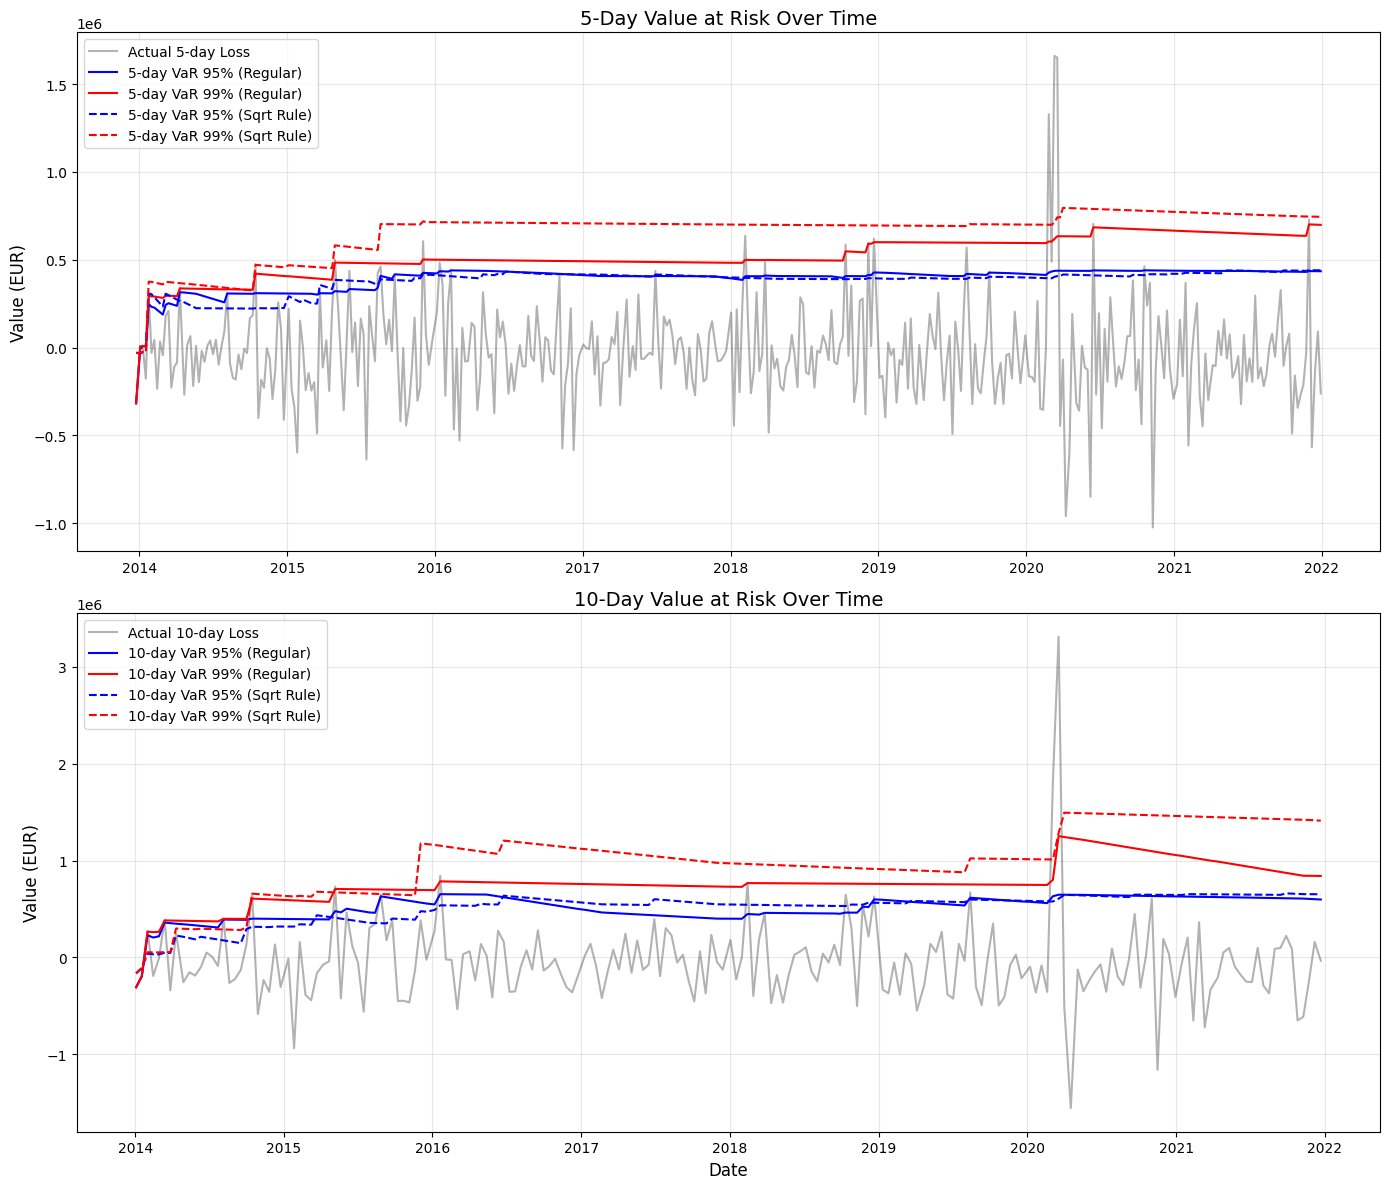

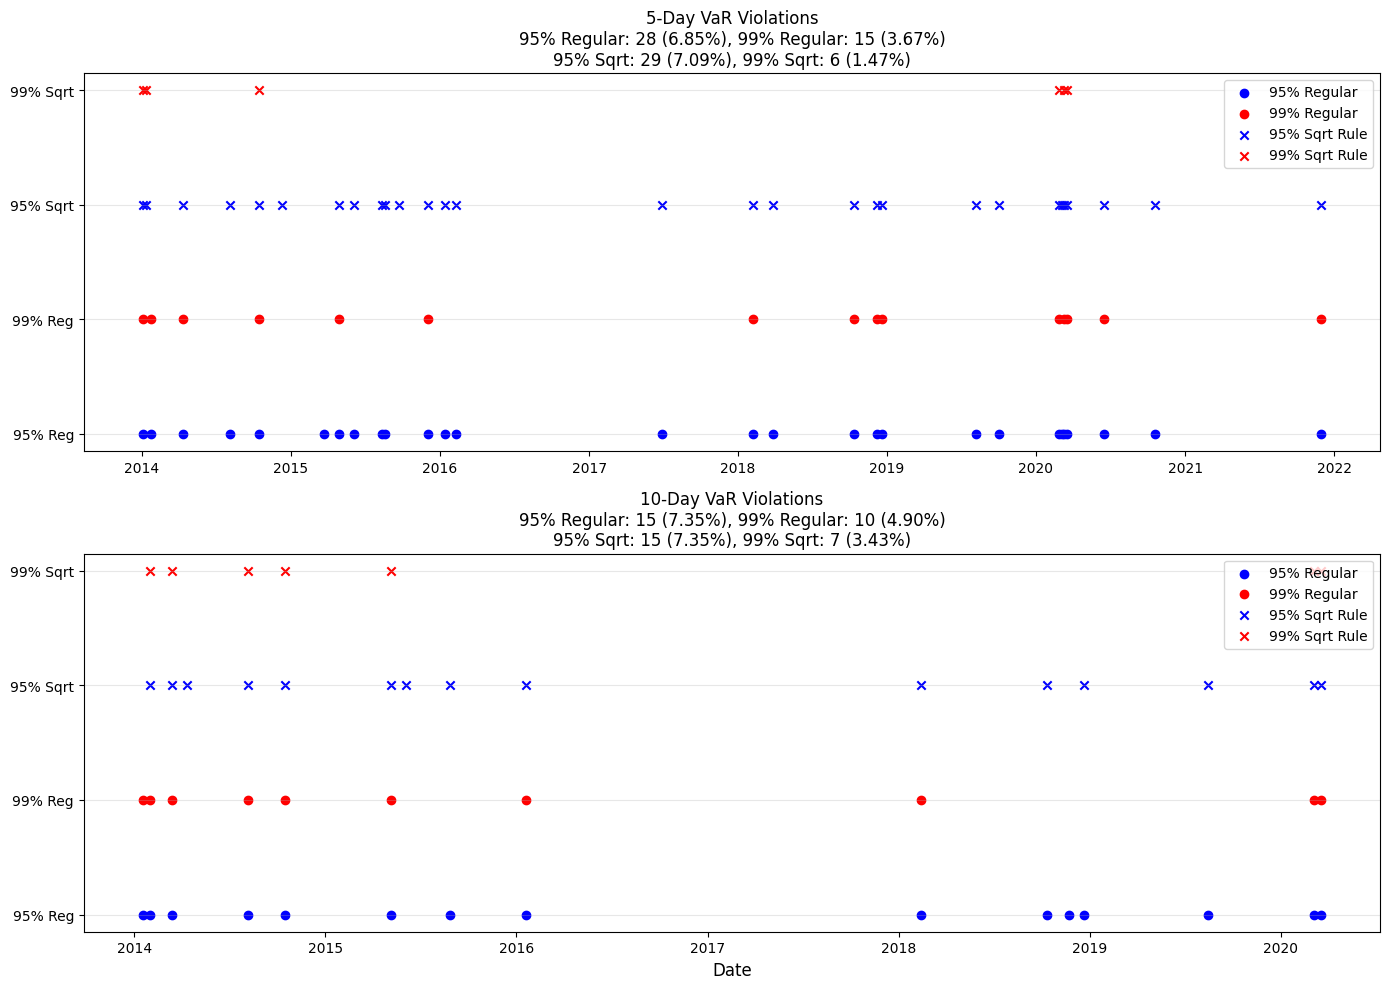

In [14]:
# Create a plot for 5-day and 10-day VaR over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=False)

# ------- 5-day VaR Plot ------- 
# Extract regular and sqrt VaR values for 95% and 99% levels
var5d_reg_95 = [row[0] for row in var_5d['VaR_5d_reg']]
var5d_reg_99 = [row[1] for row in var_5d['VaR_5d_reg']]
var5d_sqrt_95 = [row[0] for row in var_5d['VaR_5d_sqrt']]
var5d_sqrt_99 = [row[1] for row in var_5d['VaR_5d_sqrt']]

# Plot actual portfolio losses
ax1.plot(var_5d['Date'], var_5d['Portfolio_loss'], 'k-', alpha=0.3, label='Actual 5-day Loss')

# Plot regular and sqrt VaR values
ax1.plot(var_5d['Date'], var5d_reg_95, 'b-', label='5-day VaR 95% (Regular)')
ax1.plot(var_5d['Date'], var5d_reg_99, 'r-', label='5-day VaR 99% (Regular)')
ax1.plot(var_5d['Date'], var5d_sqrt_95, 'b--', label='5-day VaR 95% (Sqrt Rule)')
ax1.plot(var_5d['Date'], var5d_sqrt_99, 'r--', label='5-day VaR 99% (Sqrt Rule)')

# Customize 5-day plot
ax1.set_title('5-Day Value at Risk Over Time', fontsize=14)
ax1.set_ylabel('Value (EUR)', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# ------- 10-day VaR Plot ------- 
# Extract regular and sqrt VaR values for 95% and 99% levels
var10d_reg_95 = [row[0] for row in var_10d['VaR_10d_reg']]
var10d_reg_99 = [row[1] for row in var_10d['VaR_10d_reg']]
var10d_sqrt_95 = [row[0] for row in var_10d['VaR_10d_sqrt']]
var10d_sqrt_99 = [row[1] for row in var_10d['VaR_10d_sqrt']]

# Plot actual portfolio losses
ax2.plot(var_10d['Date'], var_10d['Portfolio_loss'], 'k-', alpha=0.3, label='Actual 10-day Loss')

# Plot regular and sqrt VaR values
ax2.plot(var_10d['Date'], var10d_reg_95, 'b-', label='10-day VaR 95% (Regular)')
ax2.plot(var_10d['Date'], var10d_reg_99, 'r-', label='10-day VaR 99% (Regular)')
ax2.plot(var_10d['Date'], var10d_sqrt_95, 'b--', label='10-day VaR 95% (Sqrt Rule)')
ax2.plot(var_10d['Date'], var10d_sqrt_99, 'r--', label='10-day VaR 99% (Sqrt Rule)')

# Customize 10-day plot
ax2.set_title('10-Day Value at Risk Over Time', fontsize=14)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Value (EUR)', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# Adjust layout to prevent clipping of labels
plt.tight_layout()
plt.show()

# Create a plot to compare the violations between 5-day and 10-day VaR
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=False)

# ----- 5-day VaR Violations -----
# Calculate violations (when actual loss exceeds VaR)
violations_5d_reg_95 = var_5d['Portfolio_loss'] > np.array(var5d_reg_95)
violations_5d_reg_99 = var_5d['Portfolio_loss'] > np.array(var5d_reg_99)
violations_5d_sqrt_95 = var_5d['Portfolio_loss'] > np.array(var5d_sqrt_95)
violations_5d_sqrt_99 = var_5d['Portfolio_loss'] > np.array(var5d_sqrt_99)

# Plot violations
ax1.scatter(var_5d['Date'][violations_5d_reg_95], [1]*sum(violations_5d_reg_95), color='blue', marker='o', label='95% Regular')
ax1.scatter(var_5d['Date'][violations_5d_reg_99], [2]*sum(violations_5d_reg_99), color='red', marker='o', label='99% Regular')
ax1.scatter(var_5d['Date'][violations_5d_sqrt_95], [3]*sum(violations_5d_sqrt_95), color='blue', marker='x', label='95% Sqrt Rule')
ax1.scatter(var_5d['Date'][violations_5d_sqrt_99], [4]*sum(violations_5d_sqrt_99), color='red', marker='x', label='99% Sqrt Rule')

# Add violation counts to the legend
ax1.set_title(f'5-Day VaR Violations\n' + 
             f'95% Regular: {sum(violations_5d_reg_95)} ({sum(violations_5d_reg_95)/len(var_5d)*100:.2f}%), ' + 
             f'99% Regular: {sum(violations_5d_reg_99)} ({sum(violations_5d_reg_99)/len(var_5d)*100:.2f}%)\n' + 
             f'95% Sqrt: {sum(violations_5d_sqrt_95)} ({sum(violations_5d_sqrt_95)/len(var_5d)*100:.2f}%), ' + 
             f'99% Sqrt: {sum(violations_5d_sqrt_99)} ({sum(violations_5d_sqrt_99)/len(var_5d)*100:.2f}%)', 
             fontsize=12)
             
ax1.set_yticks([1, 2, 3, 4])
ax1.set_yticklabels(['95% Reg', '99% Reg', '95% Sqrt', '99% Sqrt'])
ax1.legend(loc='upper right')
ax1.grid(True, axis='y', alpha=0.3)

# ----- 10-day VaR Violations -----
# Calculate violations (when actual loss exceeds VaR)
violations_10d_reg_95 = var_10d['Portfolio_loss'] > np.array(var10d_reg_95)
violations_10d_reg_99 = var_10d['Portfolio_loss'] > np.array(var10d_reg_99)
violations_10d_sqrt_95 = var_10d['Portfolio_loss'] > np.array(var10d_sqrt_95)
violations_10d_sqrt_99 = var_10d['Portfolio_loss'] > np.array(var10d_sqrt_99)

# Plot violations
ax2.scatter(var_10d['Date'][violations_10d_reg_95], [1]*sum(violations_10d_reg_95), color='blue', marker='o', label='95% Regular')
ax2.scatter(var_10d['Date'][violations_10d_reg_99], [2]*sum(violations_10d_reg_99), color='red', marker='o', label='99% Regular')
ax2.scatter(var_10d['Date'][violations_10d_sqrt_95], [3]*sum(violations_10d_sqrt_95), color='blue', marker='x', label='95% Sqrt Rule')
ax2.scatter(var_10d['Date'][violations_10d_sqrt_99], [4]*sum(violations_10d_sqrt_99), color='red', marker='x', label='99% Sqrt Rule')

# Add violation counts to the legend
ax2.set_title(f'10-Day VaR Violations\n' + 
             f'95% Regular: {sum(violations_10d_reg_95)} ({sum(violations_10d_reg_95)/len(var_10d)*100:.2f}%), ' + 
             f'99% Regular: {sum(violations_10d_reg_99)} ({sum(violations_10d_reg_99)/len(var_10d)*100:.2f}%)\n' + 
             f'95% Sqrt: {sum(violations_10d_sqrt_95)} ({sum(violations_10d_sqrt_95)/len(var_10d)*100:.2f}%), ' + 
             f'99% Sqrt: {sum(violations_10d_sqrt_99)} ({sum(violations_10d_sqrt_99)/len(var_10d)*100:.2f}%)', 
             fontsize=12)
             
ax2.set_yticks([1, 2, 3, 4])
ax2.set_yticklabels(['95% Reg', '99% Reg', '95% Sqrt', '99% Sqrt'])
ax2.set_xlabel('Date', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

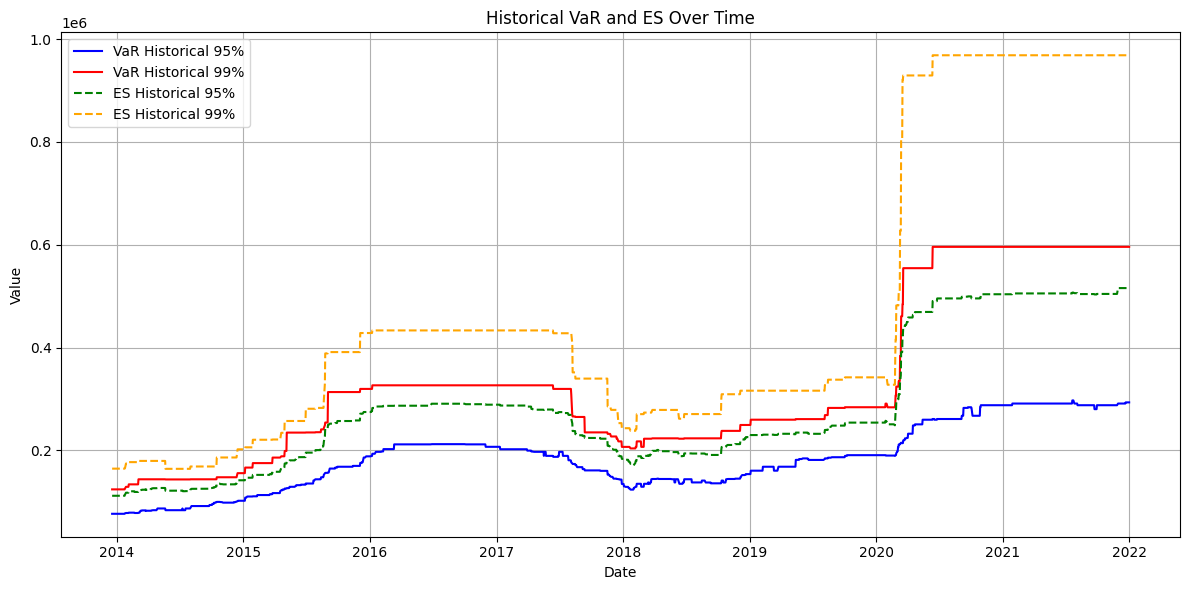

In [15]:
# Plot Historical VaR and ES over time
plt.figure(figsize=(12, 6))

# Extract the values for different confidence levels from the arrays
var_95 = [row[0] for row in var_results_df['VaR Historical']]
var_99 = [row[1] for row in var_results_df['VaR Historical']]
es_95 = [row[0] for row in es_results_df['ES Historical']]
es_99 = [row[1] for row in es_results_df['ES Historical']]

# Plot VaR Historical 95% and 99%
plt.plot(var_results_df['Date'], var_95, label='VaR Historical 95%', color='blue')
plt.plot(var_results_df['Date'], var_99, label='VaR Historical 99%', color='red')

# Plot ES Historical 95% and 99%
plt.plot(es_results_df['Date'], es_95, label='ES Historical 95%', color='green', linestyle='--')
plt.plot(es_results_df['Date'], es_99, label='ES Historical 99%', color='orange', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Historical VaR and ES Over Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

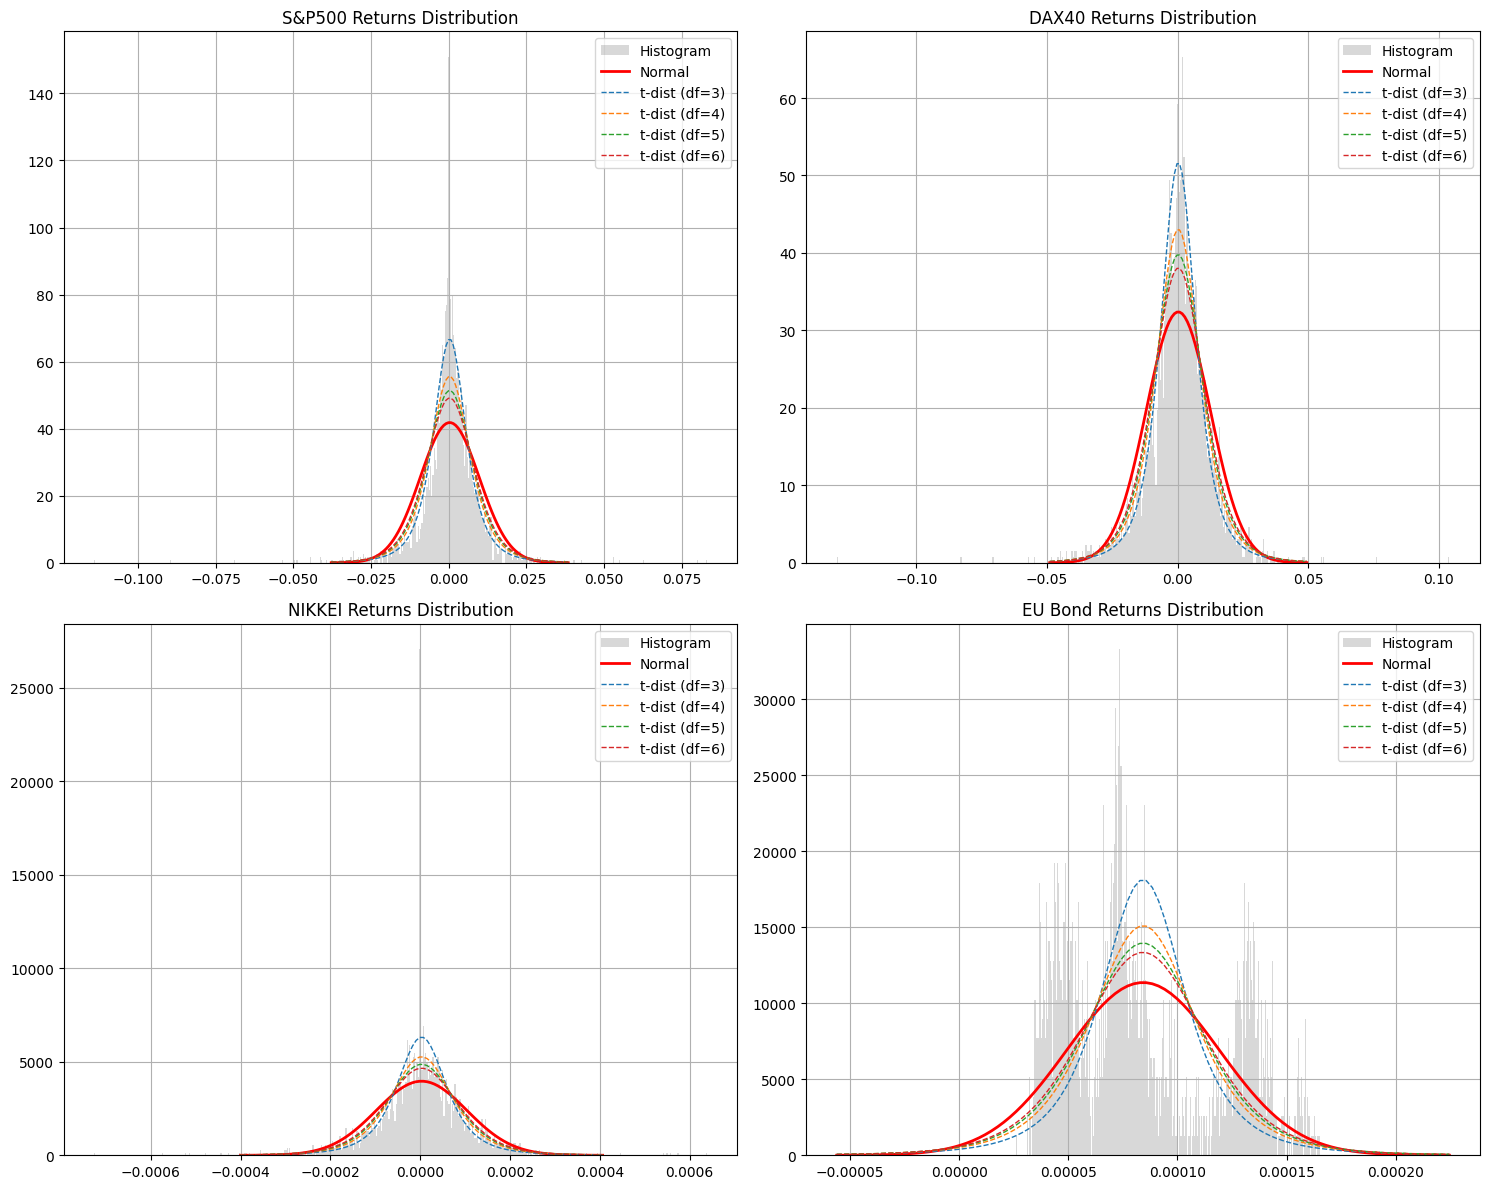

In [16]:
# Create subplots for all indices
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# S&P 500
sp500_returns = main_df['C_S&P500_Returns'].dropna()
mu_sp500 = sp500_returns.mean()
sigma_sp500 = sp500_returns.std()
x_sp500 = np.linspace(mu_sp500 - 4*sigma_sp500, mu_sp500 + 4*sigma_sp500, 100)
ax1.hist(sp500_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax1.plot(x_sp500, st.norm.pdf(x_sp500, mu_sp500, sigma_sp500), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_sp500 / np.sqrt(df/(df-2))
    ax1.plot(x_sp500, st.t.pdf((x_sp500-mu_sp500)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax1.set_title('S&P500 Returns Distribution')
ax1.legend()
ax1.grid(True)

# DAX40
dax_returns = main_df['C_Dax40_Returns'].dropna()
mu_dax = dax_returns.mean()
sigma_dax = dax_returns.std()
x_dax = np.linspace(mu_dax - 4*sigma_dax, mu_dax + 4*sigma_dax, 100)
ax2.hist(dax_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax2.plot(x_dax, st.norm.pdf(x_dax, mu_dax, sigma_dax), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_dax / np.sqrt(df/(df-2))
    ax2.plot(x_dax, st.t.pdf((x_dax-mu_dax)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax2.set_title('DAX40 Returns Distribution')
ax2.legend()
ax2.grid(True)

# NIKKEI
nikkei_returns = main_df['C_Nikkei_Returns'].dropna()
mu_nikkei = nikkei_returns.mean()
sigma_nikkei = nikkei_returns.std()
x_nikkei = np.linspace(mu_nikkei - 4*sigma_nikkei, mu_nikkei + 4*sigma_nikkei, 100)
ax3.hist(nikkei_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax3.plot(x_nikkei, st.norm.pdf(x_nikkei, mu_nikkei, sigma_nikkei), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_nikkei / np.sqrt(df/(df-2))
    ax3.plot(x_nikkei, st.t.pdf((x_nikkei-mu_nikkei)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax3.set_title('NIKKEI Returns Distribution')
ax3.legend()
ax3.grid(True)

# EU Bond
bond_returns = main_df['Interest_Bond_daily_rate'].dropna()
mu_bond = bond_returns.mean()
sigma_bond = bond_returns.std()
x_bond = np.linspace(mu_bond - 4*sigma_bond, mu_bond + 4*sigma_bond, 100)
ax4.hist(bond_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax4.plot(x_bond, st.norm.pdf(x_bond, mu_bond, sigma_bond), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_bond / np.sqrt(df/(df-2))
    ax4.plot(x_bond, st.t.pdf((x_bond-mu_bond)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax4.set_title('EU Bond Returns Distribution')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

## GARCH(1,1) with constant conditional correlation 

In [17]:
#maximum likelihood estimation of GARCH(1,1) parameters
def garch_likelihood(params, returns):
    omega, alpha, beta = params
    T = len(returns)
    var = np.zeros(T)
    var[0] = omega / (1 - alpha - beta)
    ll = 0
    for t in range(2, T):
        var[t] = omega + alpha * returns[t-1]**2 + beta * var[t-1]
        ll += 0.5 * (np.log(2 * np.pi) + np.log(var[t]) + returns[t]**2 / var[t])
    return ll


In [18]:
# GARCH(1,1) parameter estimation using MLE
# This function estimates the parameters of a GARCH(1,1) model using maximum likelihood estimation (MLE).
def parameter_estimation_GARCH(returns):
    # Run the optimization
    result = minimize(
        garch_likelihood,
        x0=[0.02, 0.13, 0.86],
        args=(returns,),
        method='SLSQP',
        bounds=[(1e-6, None), (0, 0.99), (0, 0.99)],
        constraints=[
            {'type': 'ineq', 'fun': lambda x: 0.999 - x[1] - x[2]}
        ],
        options={'disp': True}
    )

    # Return the optimization result
    return result
# result = parameter_estimation_GARCH(main_df['Portfolio_Daily_Returns'].dropna())
# Check the optimization result
# if result.success:
#     print(f"Optimized parameters: omega={result.x[0]}, alpha={result.x[1]}, beta={result.x[2]}")
# else:
#     print("Optimization failed:", result.message)


In [19]:
# calculate the GARCH(1,1) volatility for returns t
def garch_volatility(returns):
    param = [0.000002, 0.13, 0.86]
    param = type('obj', (object,), {'x': param})
    omega, alpha, beta = param.x
    T = len(returns)
    var = np.zeros(T)

    var[0]= param.x[0] / (1 - param.x[1] - param.x[2])
    for t in range(2, T):
        var[t] = omega + alpha * returns[t-1]**2 + beta * var[t-1]
    return np.sqrt(var)

In [20]:
# calculate correlation matrix of the 4 time series
# the method must take the returns as matrix of 4 vectors and return the correlation matrix
def correlation_matrix(returns):
    # Calculate the covariance matrix
    cov_matrix = np.cov(returns.T)
    
    # Calculate the standard deviations of each asset
    std_devs = np.sqrt(np.diag(cov_matrix))
    
    # Calculate the correlation matrix
    corr_matrix = cov_matrix / np.outer(std_devs, std_devs)
    
    return corr_matrix


In [21]:
# calculate the diagonal matrix with the garch volatility of the 4 time series
def diagonal_matrix(returns):
    # Initialize an empty dictionary to store volatilities for each column
    volatilities_dict = {}

    # Iterate through each column in the returns DataFrame
    for column in returns.columns:
        # Reset the index of the column to ensure numeric indexing
        column_returns = returns[column].dropna().reset_index(drop=True)
        
        # Calculate the GARCH(1,1) volatility for the column
        volatilities_dict[column] = garch_volatility(column_returns)
        
    # Combine the volatilities into a single array
    volatilities = np.array([vol[-1] for vol in volatilities_dict.values()])

    # Create a diagonal matrix with the volatilities
    #diag_matrix = np.diag(volatilities)
    
    return volatilities

In [22]:
# calculate the covariance matrix of the 4 time series
def covariance_matrix(returns, corr_matrix):
    # Calculate the GARCH(1,1) volatilities
    volatilities = diagonal_matrix(returns)
    
    # # Calculate the correlation matrix
    # corr_matrix = correlation_matrix(returns)
    
    # Calculate the covariance matrix
    cov_matrix = np.outer(volatilities, volatilities) * corr_matrix
    
    return cov_matrix

In [23]:
# method to calculate the portfolio variance and volatility
def portfolio_variance(weights, cov_matrix):
    # Calculate the portfolio variance
    port_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    
    # Calculate the portfolio volatility
    port_volatility = np.sqrt(port_variance)
    
    return port_variance, port_volatility

In [24]:
# method to calculate the VaR and ES of the portfolio using the normal distribution
def portfolio_VaR_ES(weights, cov_matrix, alpha=0.99):
    # Calculate the portfolio variance and volatility
    _, port_volatility = portfolio_variance(weights, cov_matrix)
    
    # Calculate the VaR using the normal distribution
    VaR = -port_volatility * st.norm.ppf(alpha)
    
    # Calculate the ES using the normal distribution
    ES = -port_volatility * (st.norm.pdf(st.norm.ppf(1 - alpha)) / (1 - alpha))
    
    return VaR, ES

In [25]:
def count_violations(returns, VaR, ES):
    # Ensure VaR and ES are scalar values (e.g., take the first element if they are lists)
    if isinstance(VaR, list):
        VaR = VaR[0]  # Use the first value in the list
    
    # Count the number of violations for VaR
    VaR_violations = np.sum(returns < VaR)
    
    # Calculate the relative violations
    VaR_violations = VaR_violations / len(returns)

    # count the average shortfall for the VaR violations
    ES_violations = returns[returns < VaR]
    ES_violation_av = np.mean(ES_violations) if len(ES_violations) > 0 else 0

    return VaR_violations, ES_violation_av

,Start Date,End Date,Mean S&P500 Returns
0,2012-01-04,2013-12-17,0.000714
1,2012-01-05,2013-12-18,0.000745
2,2012-01-06,2013-12-19,0.000738
3,2012-01-09,2013-12-20,0.000753
4,2012-01-10,2013-12-23,0.000759


,Start Date,End Date,Mean DAX40 Returns
0,2012-01-04,2013-12-17,0.000793
1,2012-01-05,2013-12-18,0.000812
2,2012-01-06,2013-12-19,0.000851
3,2012-01-09,2013-12-20,0.000877
4,2012-01-10,2013-12-23,0.000909


,Start Date,End Date,Mean Nikkei Returns
0,2012-01-04,2013-12-17,0.001225
1,2012-01-05,2013-12-18,0.001262
2,2012-01-06,2013-12-19,0.001313
3,2012-01-09,2013-12-20,0.001338
4,2012-01-10,2013-12-23,0.001338


,Start Date,End Date,Mean EU Bond Returns
0,2012-01-04,2013-12-17,0.000137
1,2012-01-05,2013-12-18,0.000137
2,2012-01-06,2013-12-19,0.000137
3,2012-01-09,2013-12-20,0.000137
4,2012-01-10,2013-12-23,0.000137


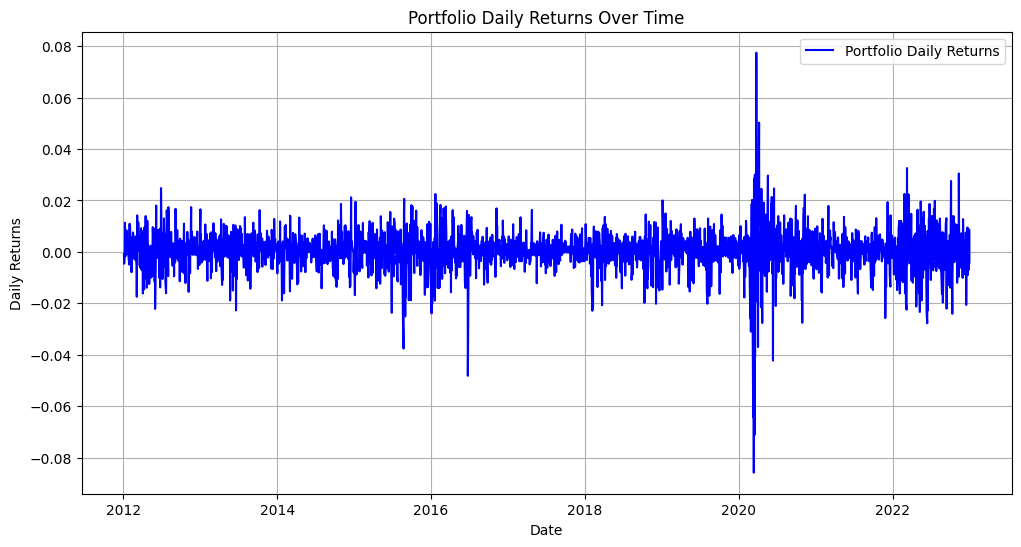

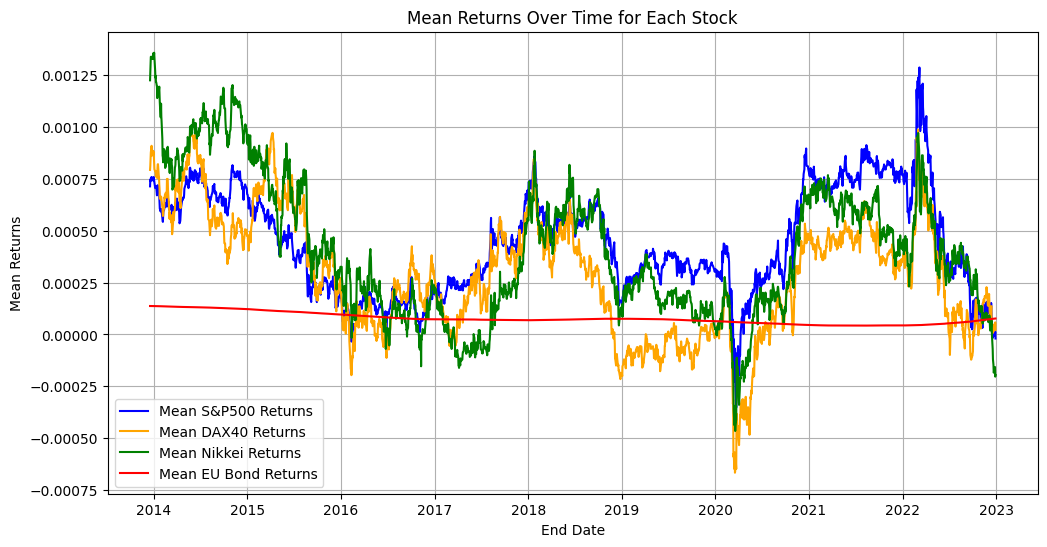

In [26]:
# checking assumption on taking mean = 0 
# Calculate portfolio daily returns
main_df['Portfolio_Daily_Returns'] = (
    weights['S&P500'] * main_df['U_S&P500_Returns'] +
    weights['DAX40'] * main_df['U_Dax40_Returns'] +
    weights['NIKKEI'] * main_df['U_Nikkei_Returns'] +
    weights['EU-BOND'] * main_df['Interest_Bond_daily_rate']
)

# make a graph of the portfolio daily returns
plt.figure(figsize=(12, 6))
plt.plot(main_df['Date'], main_df['Portfolio_Daily_Returns'], label='Portfolio Daily Returns', color='blue')
plt.title('Portfolio Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.grid()
#plt.show()

# Calculate the mean of the returns for each stock over a subset of the data defined on the time range
# Define the sample size
sample_size = 500

# Initialize variables to store the mean returns for each stock for each time window
mean_sp500_returns_list = []
mean_dax40_returns_list = []
mean_nikkei_returns_list = []
mean_eu_bond_returns_list = []

# Loop through the data with a fixed sample size
for i in range(sample_size, len(main_df)):
    time_range_start = main_df['Date'].iloc[i - sample_size]
    time_range_end = main_df['Date'].iloc[i]
    time_range_df = main_df[(main_df['Date'] >= time_range_start) & (main_df['Date'] <= time_range_end)]
    
    # Calculate mean returns for each stock
    mean_sp500_returns = time_range_df['U_S&P500_Returns'].mean()
    mean_dax40_returns = time_range_df['U_Dax40_Returns'].mean()
    mean_nikkei_returns = time_range_df['U_Nikkei_Returns'].mean()
    mean_eu_bond_returns = time_range_df['Interest_Bond_daily_rate'].mean()
    
    # Append the results to the respective lists
    mean_sp500_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean S&P500 Returns': mean_sp500_returns
    })
    mean_dax40_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean DAX40 Returns': mean_dax40_returns
    })
    mean_nikkei_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean Nikkei Returns': mean_nikkei_returns
    })
    mean_eu_bond_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean EU Bond Returns': mean_eu_bond_returns
    })

# Convert the results to DataFrames for easier analysis
mean_sp500_returns_df = pd.DataFrame(mean_sp500_returns_list)
mean_dax40_returns_df = pd.DataFrame(mean_dax40_returns_list)
mean_nikkei_returns_df = pd.DataFrame(mean_nikkei_returns_list)
mean_eu_bond_returns_df = pd.DataFrame(mean_eu_bond_returns_list)

# Display the results
display(mean_sp500_returns_df.head())
display(mean_dax40_returns_df.head())
display(mean_nikkei_returns_df.head())
display(mean_eu_bond_returns_df.head())

# Plot the mean returns for each stock over time
plt.figure(figsize=(12, 6))
plt.plot(mean_sp500_returns_df['End Date'], mean_sp500_returns_df['Mean S&P500 Returns'], label='Mean S&P500 Returns', color='blue')
plt.plot(mean_dax40_returns_df['End Date'], mean_dax40_returns_df['Mean DAX40 Returns'], label='Mean DAX40 Returns', color='orange')
plt.plot(mean_nikkei_returns_df['End Date'], mean_nikkei_returns_df['Mean Nikkei Returns'], label='Mean Nikkei Returns', color='green')
plt.plot(mean_eu_bond_returns_df['End Date'], mean_eu_bond_returns_df['Mean EU Bond Returns'], label='Mean EU Bond Returns', color='red')
plt.title('Mean Returns Over Time for Each Stock')
plt.xlabel('End Date')
plt.ylabel('Mean Returns')
plt.legend()
plt.grid()
plt.show()

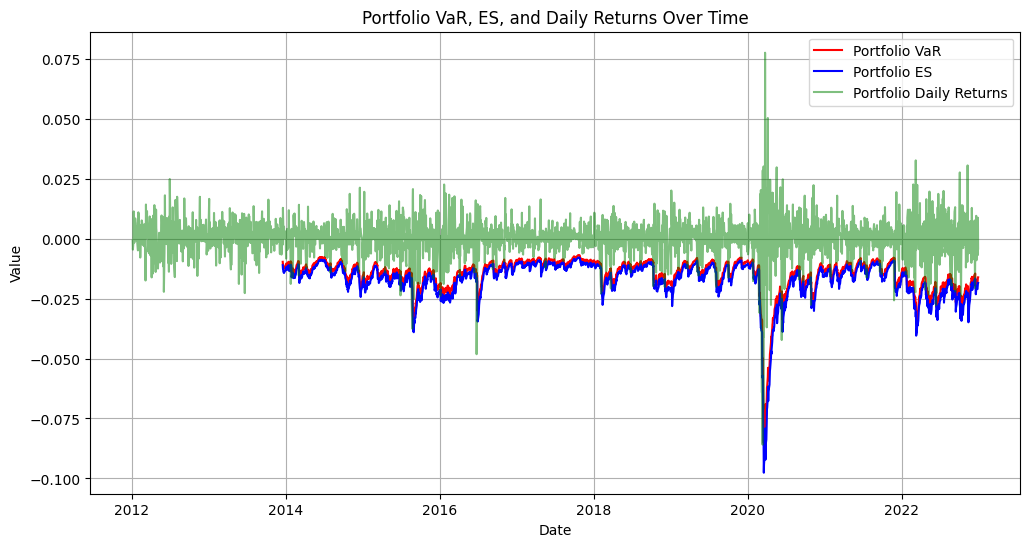

VaR Violations: 2.91%
Mean return at violation: -0.020132427762792886


,Date,Portfolio VaR,Portfolio ES,Portfolio Daily Returns
0,2013-12-17,-0.009695,-0.011107,-0.002561
1,2013-12-18,-0.010943,-0.012538,0.012804
2,2013-12-19,-0.010800,-0.012373,0.007368
3,2013-12-20,-0.012040,-0.013794,0.004113
4,2013-12-23,-0.012542,-0.014369,0.004958
...,...,...,...,...
2300,2022-12-23,-0.018109,-0.020746,0.001391
2301,2022-12-27,-0.018390,-0.021068,-0.000198
2302,2022-12-28,-0.017374,-0.019905,-0.006918
2303,2022-12-29,-0.016410,-0.018800,0.008667


In [27]:
# main function to run the analysis
def main_analysis(time_window_size):
    # Initialize lists to store results
    portfolio_VaR_list = []
    portfolio_ES_list = []
    dates = []
    corr_matrix = correlation_matrix(main_df[['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']].dropna())
    
    # Iterate through the dataset with a rolling time window
    for i in range(time_window_size, len(main_df)):
        # Extract the rolling time window
        window = main_df.iloc[i - time_window_size:i]
        current_date = main_df.iloc[i]['Date']
        
        # Calculate the returns for each asset in the window
        returns = window[['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']].dropna()

        # Define the weights for the portfolio
        weights = np.array([0.4, 0.3, 0.15, 0.15])

        # Calculate the covariance matrix
        cov_matrix = covariance_matrix(returns, corr_matrix)

        # Calculate the portfolio VaR and ES
        VaR, ES = portfolio_VaR_ES(weights, cov_matrix)

        # Append results
        portfolio_VaR_list.append(VaR)
        portfolio_ES_list.append(ES)
        dates.append(current_date)

    # Create a DataFrame to store the results
    # Calculate daily portfolio returns
    daily_portfolio_returns = main_df['Portfolio_Daily_Returns'][time_window_size:].reset_index(drop=True)

    # Create a DataFrame to store the results
    results_df = pd.DataFrame({
        'Date': dates,
        'Portfolio VaR': portfolio_VaR_list,
        'Portfolio ES': portfolio_ES_list,
        'Portfolio Daily Returns': daily_portfolio_returns
    })

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['Date'], results_df['Portfolio VaR'], label='Portfolio VaR', color='red')
    plt.plot(results_df['Date'], results_df['Portfolio ES'], label='Portfolio ES', color='blue')
    plt.plot(main_df['Date'], main_df['Portfolio_Daily_Returns'], label='Portfolio Daily Returns', color='green', alpha=0.5)
    plt.title('Portfolio VaR, ES, and Daily Returns Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()
    plt.show()

    portfolio_returns = main_df['Portfolio_Daily_Returns'][time_window_size:].reset_index(drop=True)
    # count the amount of violations via the method count_violations
    VaR_violations, ES_violations = count_violations(portfolio_returns, results_df['Portfolio VaR'], results_df['Portfolio ES'])
    print(f"VaR Violations: {VaR_violations:.2%}")
    print(f"Mean return at violation: {ES_violations}")
    
    return results_df

time_window_size = 500
main_analysis(time_window_size)

In [28]:
# show only the column names and the first 3 rows of the main dataframe
print(main_df.columns)
print(main_df.head(3))


Index(['Date', 'S&P500_Closing', 'Dax40_Closing', 'Nikkei_Closing',
       'U_S&P500_Returns', 'U_Dax40_Returns', 'U_Nikkei_Returns',
       'U_S&P500_Loss', 'U_Dax40_Loss', 'U_Nikkei_Loss', 'C_S&P500_Returns',
       'C_Dax40_Returns', 'C_Nikkei_Returns', 'C_S&P500_Loss', 'C_Dax40_Loss',
       'C_Nikkei_Loss', 'USD/EUR', 'JPY/EUR', 'TIME PERIOD',
       'Yield curve spot rate, 10-year maturity - Government bond',
       'Interest_Bond', 'Interest_Bond_Profit', 'Interest_Bond_Loss',
       'Interest_Bond_daily_rate', 'SP500_Investment', 'DAX40_Investment',
       'NIKKEI_Investment', 'EU_BOND_Investment', 'Portfolio_Value_EUR',
       'Portfolio_Change_EUR', 'Portfolio_loss', 'Portfolio_Daily_Returns'],
      dtype='object')
        Date  S&P500_Closing  Dax40_Closing  Nikkei_Closing  U_S&P500_Returns  \
0 2012-01-04     1277.300000    6111.550000     8560.110000               NaN   
1 2012-01-05     1281.060000    6095.990000     8488.710000          0.002939   
2 2012-01-06     1277

## EWMA

In [29]:
def compute_ewma_volatility(
    returns: pd.DataFrame, 
    lambdas: List[float] = [0.94, 0.97]
) -> Dict[str, pd.DataFrame]:
    """
    Compute EWMA volatility for each risk factor using different lambda values.

    Parameters:
    ----------
    returns : pd.DataFrame
        DataFrame of returns (T x N), excluding Date column
    lambdas : List[float], optional
        List of smoothing factors, by default [0.94, 0.97]

    Returns:
    -------
    Dict[str, pd.DataFrame]
        Dictionary of DataFrames containing EWMA volatilities for each lambda
    """
    # Input validation
    if not isinstance(returns, pd.DataFrame):
        raise TypeError("returns must be a pandas DataFrame")
    
    # Remove Date column if present
    if 'Date' in returns.columns:
        returns = returns.drop('Date', axis=1)
    
    results = {}
    
    for lambda_ in lambdas:
        n_obs, n_assets = returns.shape
        ewma_vol = np.zeros((n_obs, n_assets))
        
        # Initialize first value with sample standard deviation
        ewma_vol[0] = returns.iloc[0].values.std()
        
        # Loop through time to apply EWMA formula
        for t in range(1, n_obs):
            ewma_vol[t] = np.sqrt(
                lambda_ * ewma_vol[t-1]**2 + 
                (1 - lambda_) * returns.iloc[t-1].values**2
            )
        
        # Store results in dictionary
        results[f'lambda_{lambda_}'] = pd.DataFrame(
            ewma_vol,
            index=returns.index,
            columns=returns.columns
        )
    
    return results

# Example usage
returns_df = main_df[['Date', 'C_S&P500_Returns', 'C_Dax40_Returns', 
                      'C_Nikkei_Returns', 'Interest_Bond_daily_rate']].dropna()
#set Date as index
returns_df.set_index('Date', inplace=True)
ewma_results = compute_ewma_volatility(returns_df)
print(ewma_results)

{'lambda_0.94':             C_S&P500_Returns  C_Dax40_Returns  C_Nikkei_Returns  \
Date                                                              
2012-01-05          0.001718         0.001718          0.001718   
2012-01-06          0.001759         0.001779          0.001666   
2012-01-09          0.001774         0.002309          0.001616   
2012-01-10          0.001774         0.002781          0.001566   
2012-01-11          0.002415         0.006453          0.001519   
...                      ...              ...               ...   
2022-12-23          0.013447         0.011335          0.000075   
2022-12-27          0.013107         0.011000          0.000075   
2022-12-28          0.012742         0.010707          0.000072   
2022-12-29          0.012665         0.010452          0.000070   
2022-12-30          0.012907         0.010451          0.000070   

            Interest_Bond_daily_rate  
Date                                  
2012-01-05                  0.0017

In [30]:
def filter_returns(returns: pd.DataFrame, ewma_vol: dict) -> dict:
    """
    Compute standardized (filtered) returns for each lambda value.

    Parameters:
    - returns: DataFrame of raw returns
    - ewma_vol: Dictionary containing DataFrames of EWMA volatilities for each lambda

    Returns:
    - filtered_returns: Dictionary of DataFrames with standardized returns for each lambda
    """
    filtered_returns = {}
    
    # Filter returns for each lambda value
    for lambda_key, vol_df in ewma_vol.items():
        filtered_returns[lambda_key] = returns / vol_df
    
    return filtered_returns

# Assuming returns_df and ewma_vol_df (from compute_ewma_volatility) are already defined
filtered_returns_dict = filter_returns(returns_df, ewma_results)

# Preview results for both lambda values
print("\nFiltered Returns (lambda = 0.94):")
print(filtered_returns_dict['lambda_0.94'].tail())
print("\nFiltered Returns (lambda = 0.97):")
print(filtered_returns_dict['lambda_0.97'].tail())



Filtered Returns (lambda = 0.94):
            C_S&P500_Returns  C_Dax40_Returns  C_Nikkei_Returns  \
Date                                                              
2022-12-23          0.409796         0.170141         -0.982370   
2022-12-27         -0.290931         0.352562          0.150076   
2022-12-28         -0.894266        -0.464965         -0.394064   
2022-12-29          1.281939         0.998662         -0.942071   
2022-12-30         -0.184111        -1.012553          0.003226   

            Interest_Bond_daily_rate  
Date                                  
2022-12-23                  1.093727  
2022-12-27                  1.097422  
2022-12-28                  1.096478  
2022-12-29                  1.091148  
2022-12-30                  1.092670  

Filtered Returns (lambda = 0.97):
            C_S&P500_Returns  C_Dax40_Returns  C_Nikkei_Returns  \
Date                                                              
2022-12-23          0.372714         0.166877        

In [31]:
def filtered_historical_simulation_multivariate(filtered_returns_dict: dict, ewma_vol_dict: dict,
                                              n_simulations: int = 10000, random_seed: int = None, 
                                              weights: np.ndarray = None) -> dict:
    """
    Perform Filtered Historical Simulation for a multi-asset portfolio for different lambda values.

    Parameters:
    - filtered_returns_dict: Dictionary of DataFrames of standardized residuals for each lambda
    - ewma_vol_dict: Dictionary of DataFrames of EWMA volatility for each lambda
    - n_simulations: number of simulated return vectors
    - random_seed: for reproducibility
    - weights: portfolio weights (numpy array of shape [n_assets])

    Returns:
    - Dictionary containing simulated portfolio returns for each lambda value
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    results = {}
    
    # Process each lambda value
    for lambda_key in filtered_returns_dict.keys():
        filtered_returns = filtered_returns_dict[lambda_key]
        # print(filtered_returns)
        ewma_vol = ewma_vol_dict[lambda_key]
        
        assets = filtered_returns.columns
        print(f"Assets: {assets}")
        n_assets = len(assets)
        
        # Initialize simulated return matrix (n_simulations x n_assets)
        sim_returns = np.zeros((n_simulations, n_assets))

        for i, asset in enumerate(assets):
            if asset == 'Date':
                continue
            z_asset = filtered_returns[asset].dropna().values
            print(f"z_asset: {z_asset}")
            z_star = np.random.choice(z_asset, size=n_simulations, replace=True)
            print(f"z_star: {z_star}")
            sigma_t = ewma_vol[asset].iloc[-1]  # latest volatility for asset
            sim_returns[:, i] = sigma_t * z_star  # re-scale

        if weights is not None:
            portfolio_simulated_returns = sim_returns @ weights
            results[lambda_key] = pd.Series(portfolio_simulated_returns, 
                                          name=f"Simulated_Portfolio_Returns_{lambda_key}")
        else:
            results[lambda_key] = pd.DataFrame(sim_returns, columns=assets)

    return results

# Define weights in the same order as your DataFrame columns
weights = np.array([0.4, 0.3, 0.15, 0.15])  # Example: S&P500, DAX, Nikkei, Bond rate

# Run multivariate FHS simulation for both lambda values
simulated_returns = filtered_historical_simulation_multivariate(
    filtered_returns_dict,
    ewma_results,
    n_simulations=10000,
    random_seed=42,
    weights=weights
)

# Compute VaR and ES for 95% and 99% for each lambda value
confidence_levels = [0.95, 0.99]
results = {}

for lambda_key, sim_returns in simulated_returns.items():
    for cl in confidence_levels:
        alpha = 1 - cl
        percentile = alpha * 100
        var = -np.percentile(sim_returns, percentile)
        es = -sim_returns[sim_returns <= -var].mean()
        results[f"{lambda_key}_VaR_{int(cl * 100)}"] = var
        results[f"{lambda_key}_ES_{int(cl * 100)}"] = es

# Print results
for lambda_key in simulated_returns.keys():
    print(f"\nResults for {lambda_key}:")
    for cl in confidence_levels:
        print(f"Portfolio 1-day VaR ({int(cl * 100)}%): {results[f'{lambda_key}_VaR_{int(cl * 100)}']:.5f}")
        print(f"Portfolio 1-day ES  ({int(cl * 100)}%): {results[f'{lambda_key}_ES_{int(cl * 100)}']:.5f}")



Assets: Index(['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns',
       'Interest_Bond_daily_rate'],
      dtype='object')
z_asset: [ 1.33787388 -1.13549327  0.99763756 ... -0.8942656   1.28193859
 -0.18411052]
z_star: [-0.37424382 -1.42907661 -1.4122883  ... -0.19876735  2.06650442
 -0.16672369]
z_asset: [-1.48357042 -3.52115683 -2.91913437 ... -0.46496539  0.99866185
 -1.01255345]
z_star: [ 0.53711372  0.86197465  1.42165999 ...  0.81970926  0.35231205
 -0.29390161]
z_asset: [-0.04933025 -0.07142162  0.         ... -0.3940643  -0.94207061
  0.00322616]
z_star: [-1.9175504   1.37578918  1.68659133 ... -1.5428208   0.44484457
  1.07700473]
z_asset: [0.09564513 0.09870366 0.10104051 ... 1.09647804 1.09114795 1.0926701 ]
z_star: [1.00393218 1.01057632 0.84811626 ... 0.96727998 1.17706123 0.90040646]
Assets: Index(['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns',
       'Interest_Bond_daily_rate'],
      dtype='object')
z_asset: [ 1.33787388 -1.14856064  1.01300172 ... 

In [32]:
def filtered_historical_simulation_multiday(
    filtered_returns_dict: dict,
    ewma_vol_dict: dict,
    lambda_key: str,
    n_days: int = 1,
    n_simulations: int = 10000,
    random_seed: int = None,
    weights: np.ndarray = None
) -> pd.Series:
    """
    Simulate N-day portfolio returns using Filtered Historical Simulation.

    Returns:
    - Simulated N-day portfolio return series (n_simulations,)
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    filtered_returns = filtered_returns_dict[lambda_key]
    ewma_vol = ewma_vol_dict[lambda_key]

    assets = filtered_returns.columns
    n_assets = len(assets)
    sim_returns = np.zeros((n_simulations, n_days, n_assets))

    for i, asset in enumerate(assets):
        z_asset = filtered_returns[asset].dropna().values
        sigma_t = ewma_vol[asset].iloc[-1]

        if len(z_asset) == 0 or np.isnan(sigma_t):
            raise ValueError(f"Cannot simulate for asset '{asset}': empty or invalid data.")

        for day in range(n_days):
            z_star = np.random.choice(z_asset, size=n_simulations, replace=True)
            sim_returns[:, day, i] = sigma_t * z_star

    # Combine all simulated daily returns into N-day portfolio PnL
    total_pnl = (sim_returns @ weights).sum(axis=1)

    return pd.Series(total_pnl, name=f"Simulated_{n_days}Day_Returns_{lambda_key}")


# Example usage with both lambda values
confidence_levels = [0.95, 0.99]
horizons = [1, 5, 10]
lambda_keys = ['lambda_0.94', 'lambda_0.97']

for lambda_key in lambda_keys:
    print(f"\n=== Results for {lambda_key} ===")
    for days in horizons:
        print(f"\n--- {days}-Day VaR & ES ---")
        sim_returns = filtered_historical_simulation_multiday(
            filtered_returns_dict,
            ewma_results,
            lambda_key,
            n_days=days,
            n_simulations=10000,
            random_seed=42,
            weights=weights
        )

        for cl in confidence_levels:
            alpha = 1 - cl
            percentile = alpha * 100
            var = -np.percentile(sim_returns, percentile)
            es = -sim_returns[sim_returns <= -var].mean()
            print(f"VaR ({int(cl*100)}%): {var:.5f} | ES ({int(cl*100)}%): {es:.5f}")



=== Results for lambda_0.94 ===

--- 1-Day VaR & ES ---
VaR (95%): 0.01033 | ES (95%): 0.01537
VaR (99%): 0.01861 | ES (99%): 0.02423

--- 5-Day VaR & ES ---
VaR (95%): 0.02305 | ES (95%): 0.03072
VaR (99%): 0.03513 | ES (99%): 0.04178

--- 10-Day VaR & ES ---
VaR (95%): 0.03160 | ES (95%): 0.04175
VaR (99%): 0.04755 | ES (99%): 0.05714

=== Results for lambda_0.97 ===

--- 1-Day VaR & ES ---
VaR (95%): 0.01102 | ES (95%): 0.01667
VaR (99%): 0.02021 | ES (99%): 0.02632

--- 5-Day VaR & ES ---
VaR (95%): 0.02477 | ES (95%): 0.03320
VaR (99%): 0.03858 | ES (99%): 0.04552

--- 10-Day VaR & ES ---
VaR (95%): 0.03371 | ES (95%): 0.04481
VaR (99%): 0.05075 | ES (99%): 0.06152


In [33]:
def rolling_fhs_multiday_var_es(
    returns_df: pd.DataFrame,
    weights: np.ndarray,
    window_size: int = 500,
    horizons: list = [1, 5, 10],
    confidence_levels: list = [0.95, 0.99],
    n_simulations: int = 1000,
    lambdas: list = [0.94, 0.97],
    random_seed: int = None
) -> tuple:
    """
    Rolling Filtered Historical Simulation for multi-day VaR & ES.
    """
    time_window = returns_df.loc['2012-01-05':'2021-12-31']

    var_results = []
    es_results = []

    for horizon in horizons:
        adjusted_window_size = int(window_size / horizon)

        for t in range(adjusted_window_size, len(time_window)):
            current_date = time_window.index[t]
            var_row = {'index': current_date}
            es_row = {'index': current_date}

            window = time_window.iloc[t - adjusted_window_size:t]


            try:
                # Compute EWMA vol
                ewma_results = compute_ewma_volatility(
                    window[['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']],
                    lambdas
                )
                # Filtered returns
                filtered_returns_dict = {}
                for lambda_key, vol_df in ewma_results.items():
                    safe_vol_df = vol_df.replace(0, np.nan).ffill()
                    filtered_returns = window[['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']] / safe_vol_df
                    filtered_returns_dict[lambda_key] = filtered_returns

                # Simulate for each lambda and confidence level
                for lambda_key in ewma_results.keys():
                    sim_returns = filtered_historical_simulation_multiday(
                        filtered_returns_dict,
                        ewma_results,
                        lambda_key,
                        n_days=horizon,
                        n_simulations=n_simulations,
                        weights=weights,
                        random_seed=random_seed
                    )

                    for cl in confidence_levels:
                        alpha = 1 - cl
                        var = np.percentile(sim_returns, 100 * alpha)
                        es = sim_returns[sim_returns <= var].mean()

                        var_key = f"VaR_{int(cl * 100)}_{lambda_key}_h{horizon}"
                        es_key = f"ES_{int(cl * 100)}_{lambda_key}_h{horizon}"

                        var_row[var_key] = var
                        es_row[es_key] = es

                    var_results.append(var_row)
                    es_results.append(es_row)

            except Exception as e:
                continue
    var_df = pd.DataFrame(var_results).set_index('index')
    es_df = pd.DataFrame(es_results).set_index('index')

    var_df.index.name = 'Date'
    es_df.index.name = 'Date'

    return var_df, es_df

In [34]:
def plot_var_es_vs_actual_given_actuals(var_df, es_df, actual_returns_dict, lambdas, horizons, confidence_levels):
    """
    Plot VaR and ES against already computed actual portfolio returns.

    Parameters:
    - var_df: DataFrame of rolling VaR values
    - es_df: DataFrame of rolling ES values
    - actual_returns_dict: Dict of actual portfolio return Series keyed by horizon
    - lambdas: list of lambda values used (e.g. [0.94, 0.97])
    - horizons: list of horizon days (e.g. [1, 5, 10])
    - confidence_levels: list of confidence levels (e.g. [0.95, 0.99])
    """
    for h in horizons:
        actual_returns = actual_returns_dict[h].reindex(var_df.index)

        for lambda_ in lambdas:
            lambda_key = f"lambda_{lambda_}"

            for cl in confidence_levels:
                var_col = f"VaR_{int(cl * 100)}_{lambda_key}_h{h}"
                es_col = f"ES_{int(cl * 100)}_{lambda_key}_h{h}"

                plt.figure(figsize=(14, 5))
                plt.plot(actual_returns, label="Actual Portfolio Return", alpha=0.6)
                plt.plot(-var_df[var_col], label=f"VaR {int(cl * 100)}%", color='red', linestyle='--')
                plt.plot(-es_df[es_col], label=f"ES {int(cl * 100)}%", color='orange', linestyle=':')
                plt.title(f"{h}-Day VaR and ES vs Actual Returns | λ={lambda_} | CL={int(cl*100)}%")
                plt.axhline(0, color='gray', linestyle='-')
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()


In [35]:
def compute_actual_portfolio_returns(returns_df, weights, horizons=[1, 5, 10]):
    actual_returns = {}
    weighted_returns = returns_df @ weights

    for h in horizons:
        actual_returns[h] = weighted_returns.rolling(window=h).sum().shift(-h + 1)
        actual_returns[h].name = f"Actual_{h}d"

    return actual_returns

actual_returns_dict = compute_actual_portfolio_returns(returns_df, weights)
returns_dfe = pd.DataFrame(actual_returns_dict)
display(returns_dfe)

,1,5,10
Date,,,
2012-01-05,0.000167,0.005793,0.019343
2012-01-06,-0.002671,0.007674,0.023634
2012-01-09,-0.001290,0.007065,0.026003
2012-01-10,0.009980,0.012089,0.028968
2012-01-11,-0.000392,0.008660,0.017889
...,...,...,...
2022-12-23,0.002795,0.001962,NaN
2022-12-27,-0.000337,NaN,NaN
2022-12-28,-0.006032,NaN,NaN


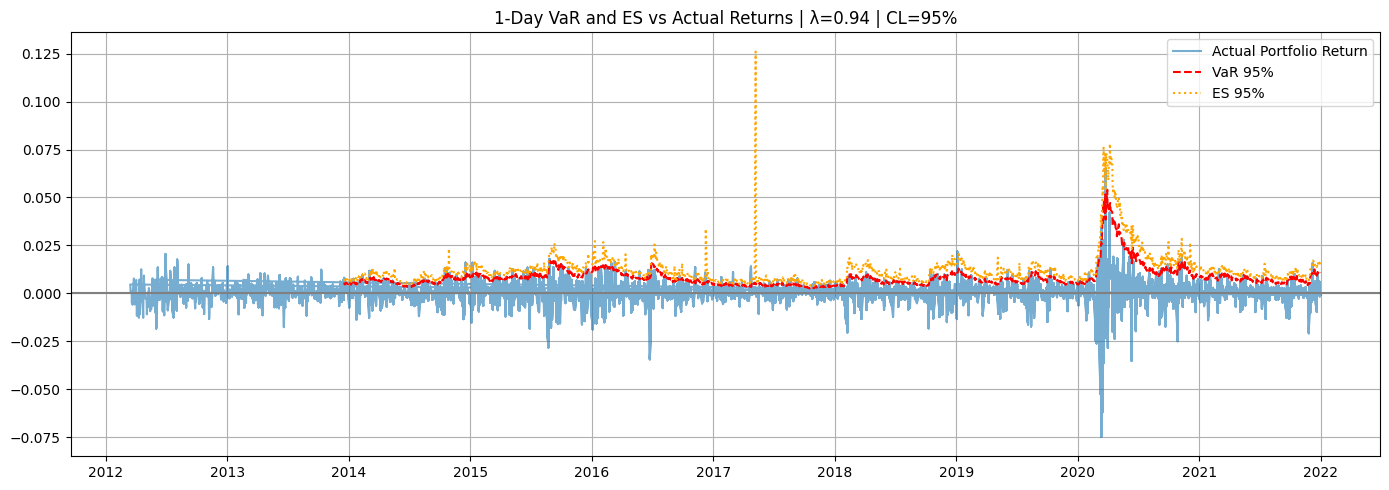

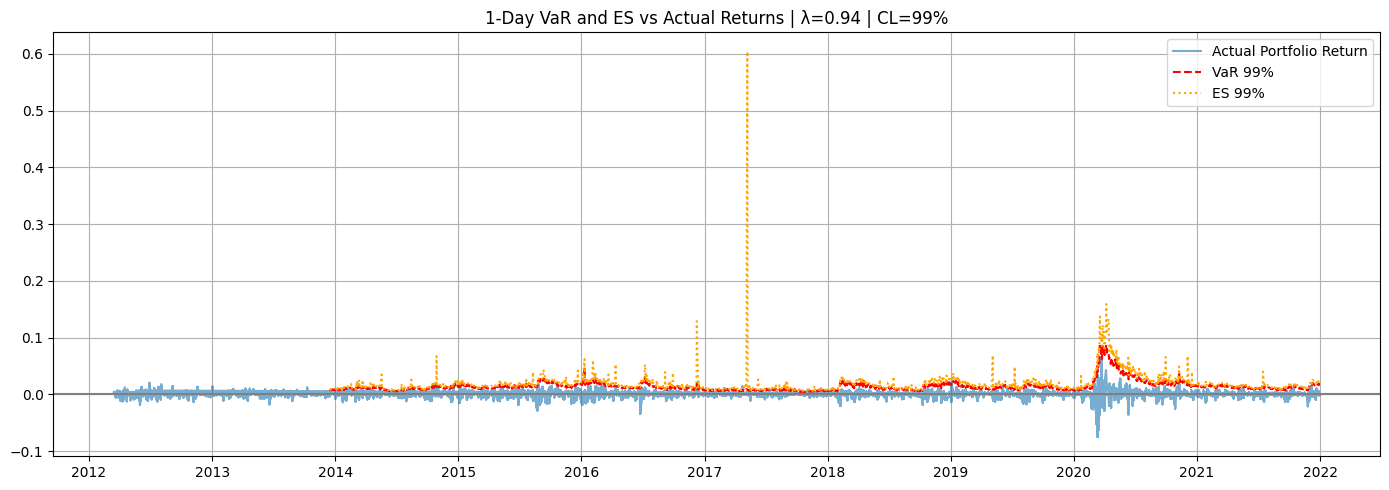

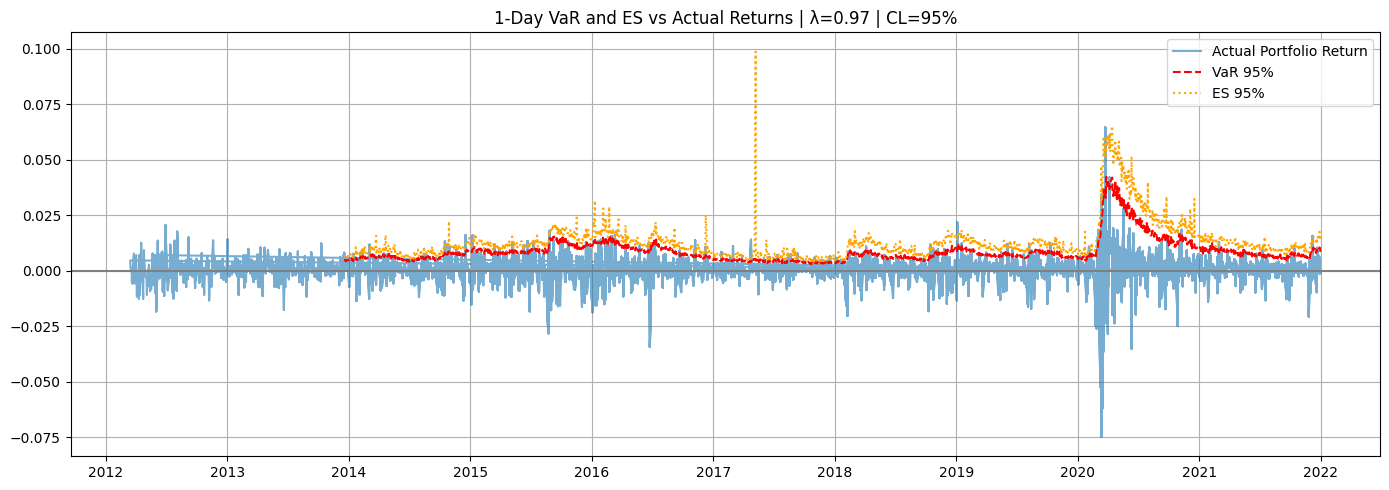

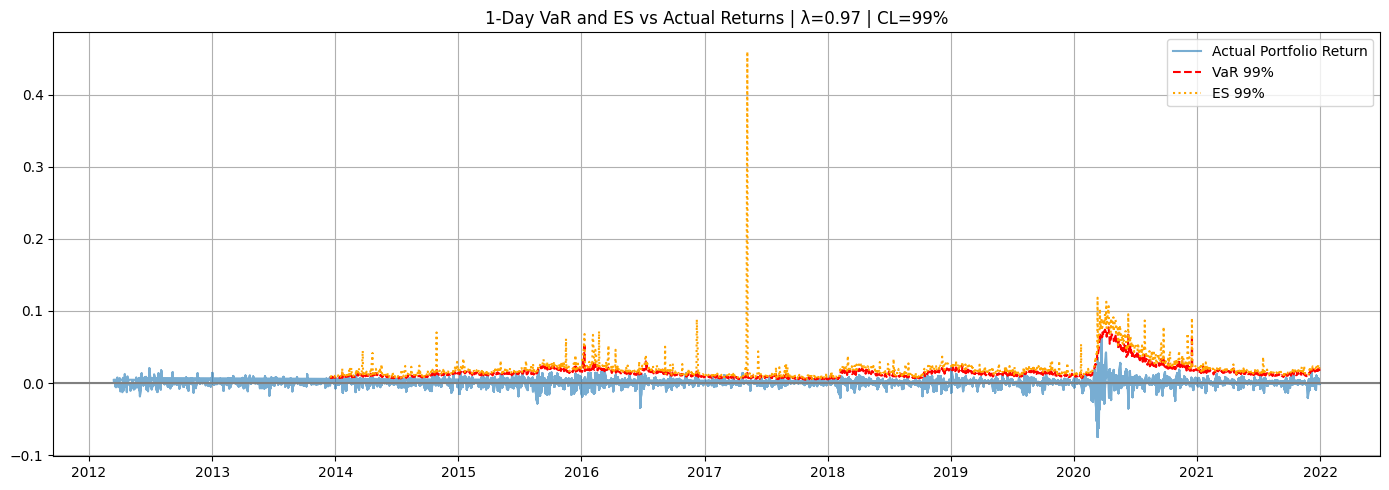

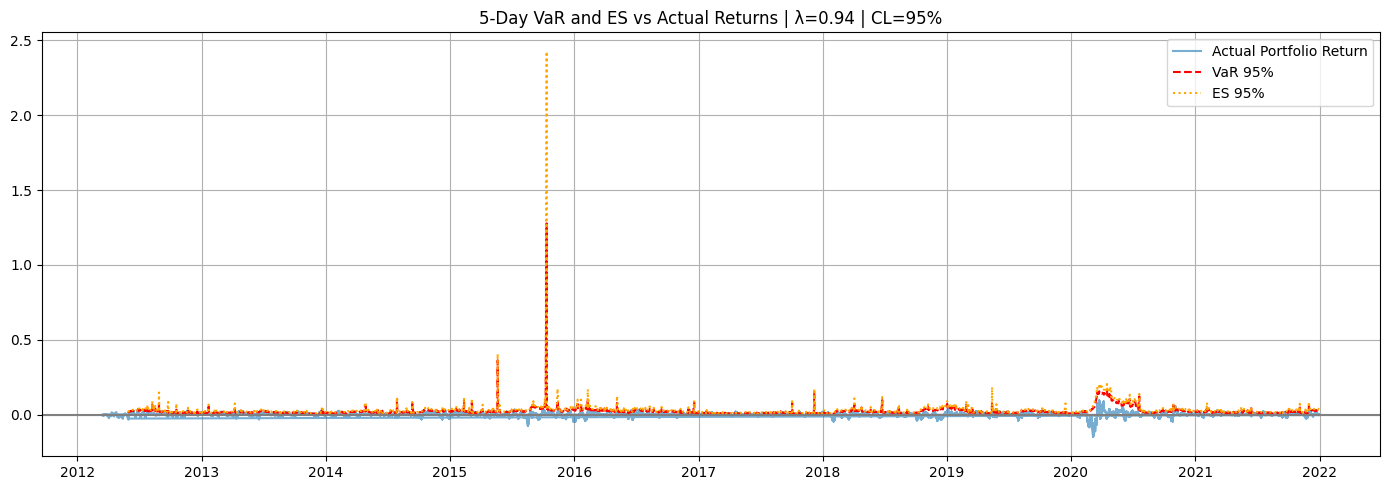

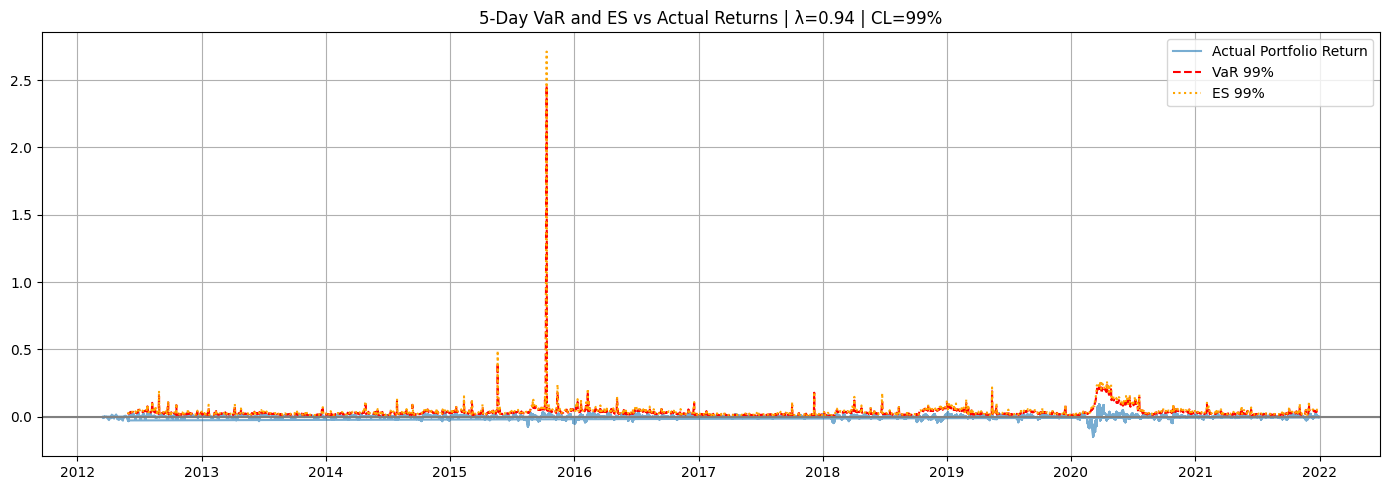

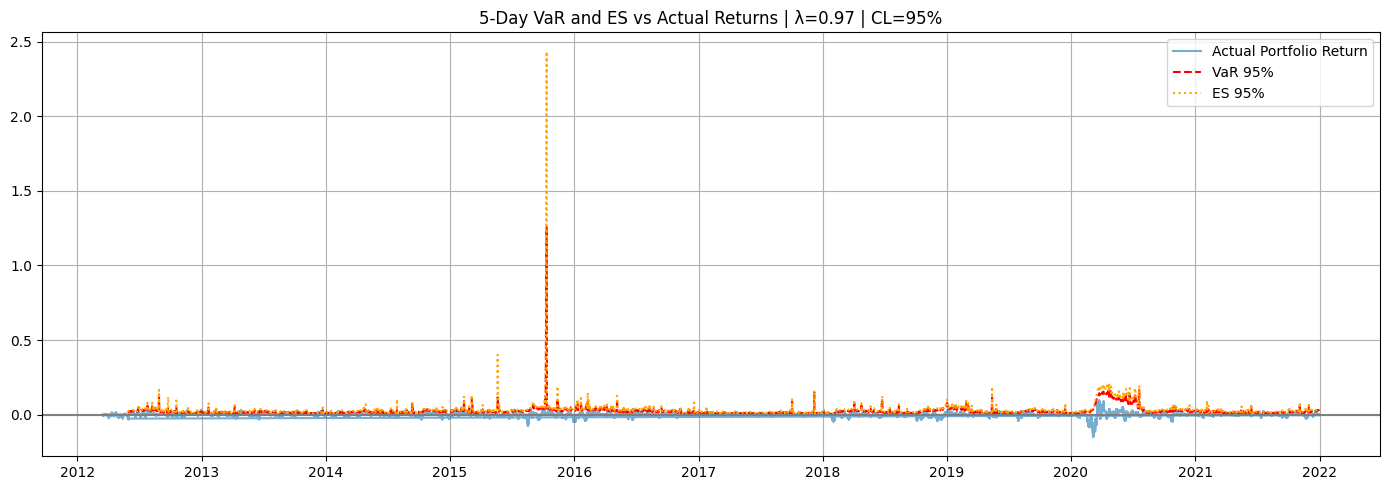

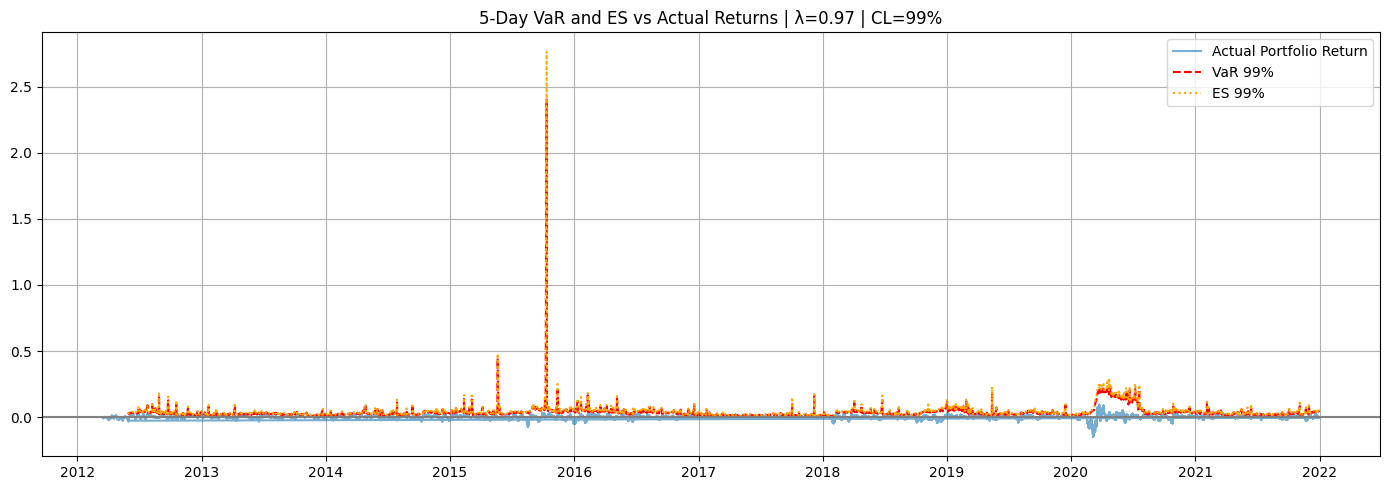

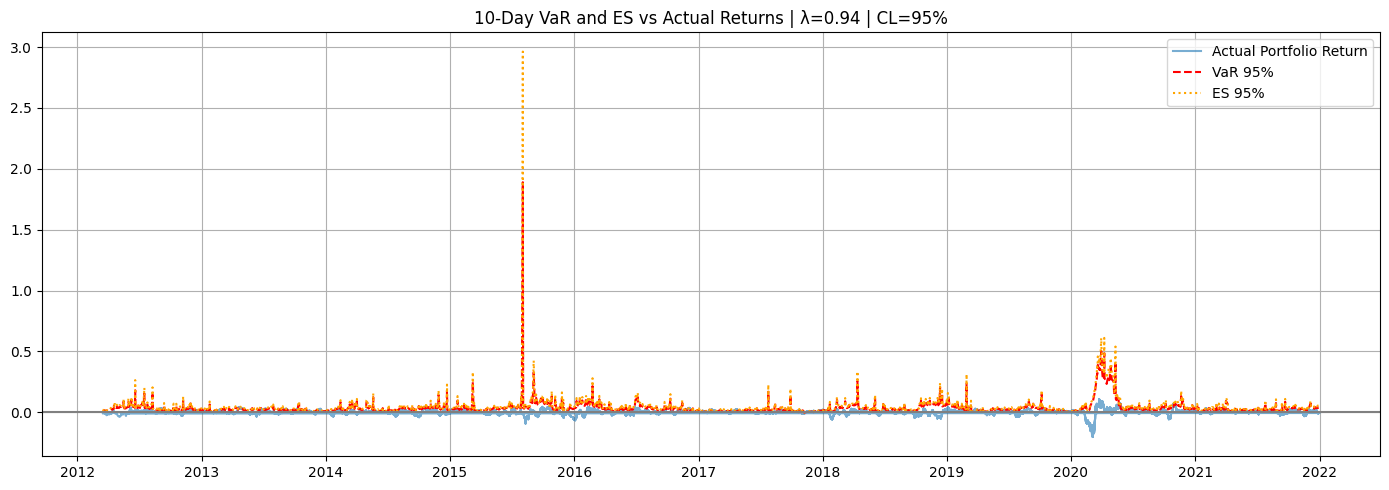

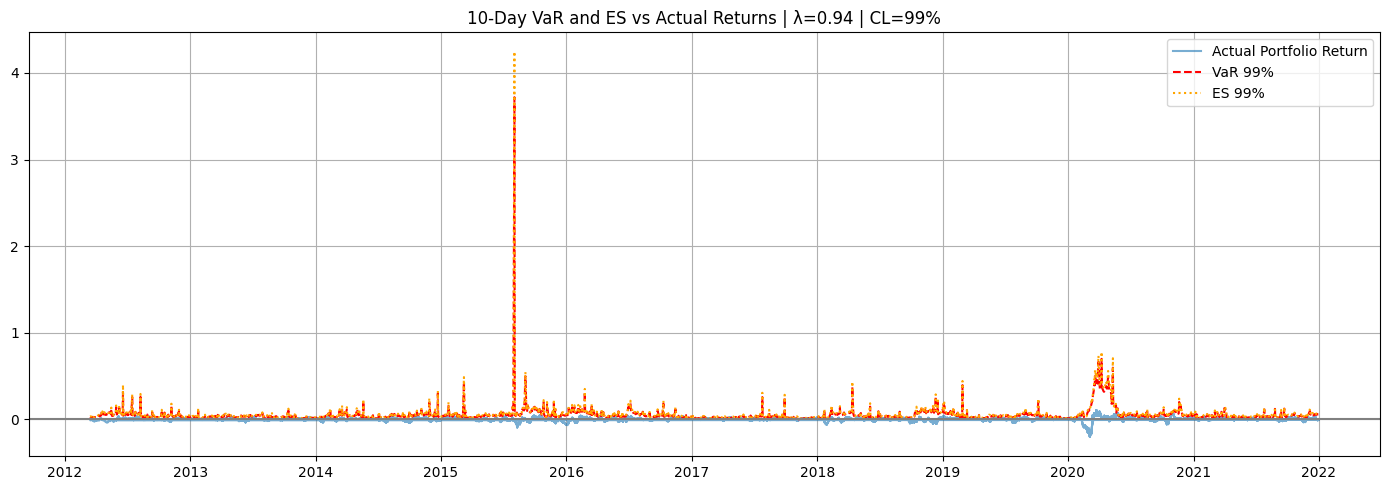

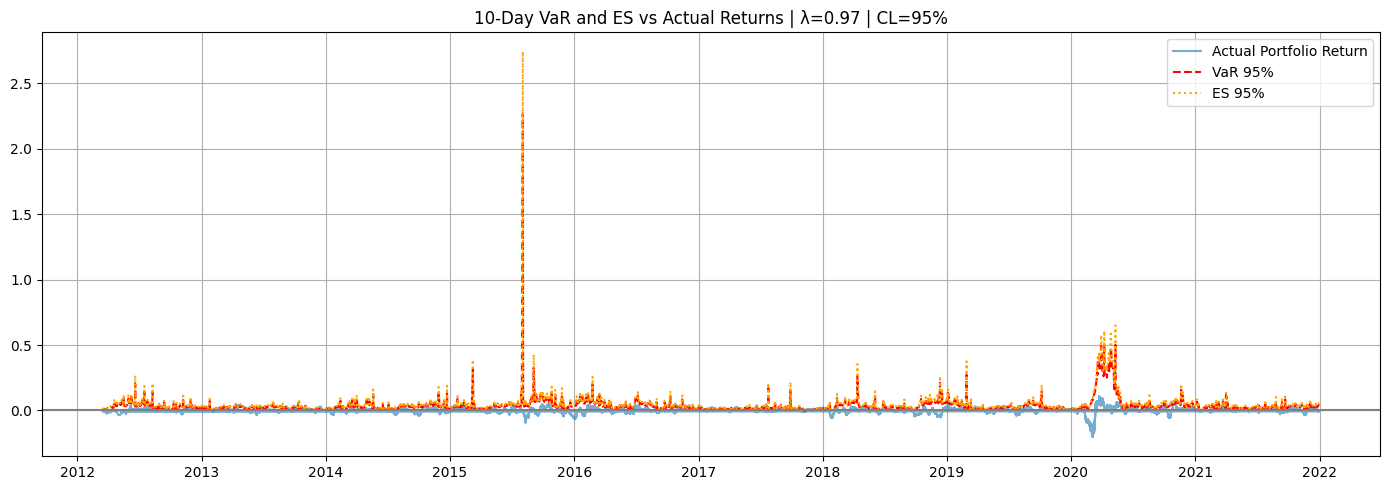

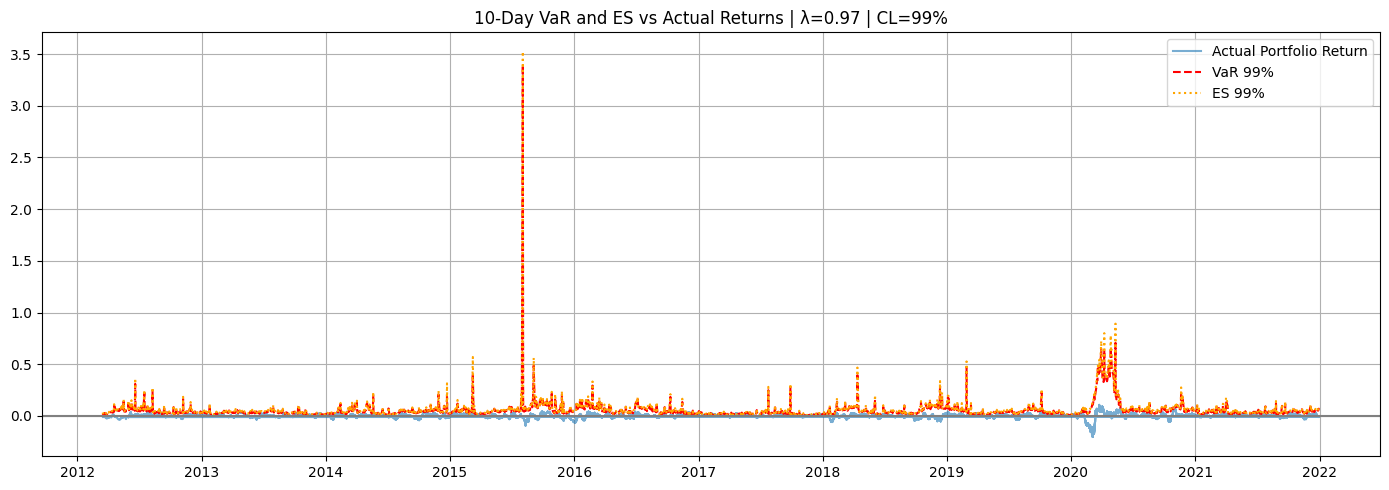

In [36]:
# Calculate VaR and ES using rolling FHS
var_df, es_df = rolling_fhs_multiday_var_es(
    returns_df=returns_df,  # DataFrame containing returns
    weights=weights,        # Portfolio weights
    window_size=500,       # Base window size
    horizons=[1, 5, 10],   # Horizons for VaR calculation
    confidence_levels=[0.95, 0.99],  # Confidence levels
    n_simulations=1000,    # Number of simulations
    lambdas=[0.94, 0.97]   # EWMA lambda values
)

# Plot the results
plot_var_es_vs_actual_given_actuals(
    var_df=var_df,
    es_df=es_df,
    actual_returns_dict=actual_returns_dict,
    lambdas=[0.94, 0.97],
    horizons=[1, 5, 10],
    confidence_levels=[0.95, 0.99]
)


# Backtesting VaR and ES

In this section, we perform backtesting on the calculated Value at Risk (VaR) and Expected Shortfall (ES) measures. Backtesting helps assess the accuracy and reliability of the risk models.

We will:
1.  **Calculate Violations:** Identify the days where the actual portfolio loss exceeded the predicted VaR.
2.  **Compare Actual vs. Expected Violations (VaR):** Group violations by year and compare the observed number of violations against the number expected based on the confidence level (alpha).
3.  **Compare Actual Shortfall vs. Predicted ES (ES):** For the days a violation occurred, compare the average actual loss (shortfall) against the predicted ES, grouped by year.
4.  **Visualize Violations:** Plot the occurrences of violations over time to visually inspect for clustering or patterns.

In [37]:
def calculate_violations(actual_losses, var_predictions):
    """Checks for VaR violations."""
    return actual_losses > var_predictions

def backtest_var(violations, alpha, dates):
    """Compares actual vs. expected VaR violations yearly."""
    if not isinstance(violations, pd.Series):
        violations = pd.Series(violations, index=dates)
    elif violations.index.name != 'Date': # Ensure index is Date for grouping
         violations = violations.set_index(dates)
            
    violations_df = pd.DataFrame({'Violations': violations, 'Year': violations.index.year})
    yearly_violations = violations_df.groupby('Year')['Violations'].sum()
    yearly_counts = violations_df.groupby('Year')['Violations'].count()
    
    expected_violations = yearly_counts * (1 - alpha)
    
    summary = pd.DataFrame({
        'Actual Violations': yearly_violations,
        'Expected Violations': expected_violations,
        'Total Observations': yearly_counts
    })
    return summary

def backtest_es(actual_losses, violations, es_predictions, dates):
    """Compares actual average shortfall vs. predicted ES yearly."""
    # Ensure inputs are pandas Series with Date index
    if not isinstance(actual_losses, pd.Series):
        actual_losses = pd.Series(actual_losses, index=dates)
    elif actual_losses.index.name != 'Date':
        actual_losses = actual_losses.set_index(dates)
        
    if not isinstance(violations, pd.Series):
        violations = pd.Series(violations, index=dates)
    elif violations.index.name != 'Date':
        violations = violations.set_index(dates)
        
    if not isinstance(es_predictions, pd.Series):
        es_predictions = pd.Series(es_predictions, index=dates)
    elif es_predictions.index.name != 'Date':
        es_predictions = es_predictions.set_index(dates)

    results_df = pd.DataFrame({
        'Actual_Loss': actual_losses,
        'Violation': violations,
        'Predicted_ES': es_predictions,
        'Year': actual_losses.index.year
    })
    
    # Filter for violations
    violation_data = results_df[results_df['Violation']]
    
    # Calculate yearly averages
    yearly_avg_actual_shortfall = violation_data.groupby('Year')['Actual_Loss'].mean()
    yearly_avg_predicted_es = violation_data.groupby('Year')['Predicted_ES'].mean()
    yearly_violation_count = violation_data.groupby('Year').size()

    summary = pd.DataFrame({
        'Avg Actual Shortfall': yearly_avg_actual_shortfall,
        'Avg Predicted ES': yearly_avg_predicted_es,
        'Violation Count': yearly_violation_count
    })
    return summary

def plot_violations(violations, dates, title):
    """Plots VaR violations over time."""
    plt.figure(figsize=(15, 4))
    plt.plot(dates, violations, 'ro', markersize=4, alpha=0.7, label='Violation')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Violation (1=Yes, 0=No)')
    plt.yticks([0, 1])
    plt.grid(axis='y', linestyle='--')
    plt.show()

def run_backtesting(main_df, var_results_df, es_results_df):
    """Runs the backtesting process for VaR and ES models."""
    # Align main_df with var/es results (which start after the initial window)
    backtest_dates = var_results_df['Date']
    backtest_data = main_df[main_df['Date'].isin(backtest_dates)].set_index('Date')
    actual_losses = backtest_data['Portfolio_loss']

    # Confidence levels used
    alphas = [0.95, 0.99]
    alpha_indices = {0.95: 0, 0.99: 1} # Index mapping for results arrays

    # Iterate through models (columns in var_results_df/es_results_df)
    var_model_cols = [col for col in var_results_df.columns if col != 'Date']
    es_model_cols = [col for col in es_results_df.columns if col != 'Date']

    for i, model_name in enumerate(var_model_cols):
        print(f"\n--- Backtesting for Model: {model_name} ---")
        
        # Extract predictions for this model
        # Need to handle the fact that predictions are stored as arrays [pred_95, pred_99]
        var_preds_list = var_results_df[model_name].tolist()
        # Ensure alignment between var and es model columns
        if i < len(es_model_cols):
            es_preds_list = es_results_df[es_model_cols[i]].tolist()
        else:
            print(f"  Warning: No matching ES column found for {model_name}. Skipping ES backtest.")
            es_preds_list = None
        
        for alpha in alphas:
            alpha_idx = alpha_indices[alpha]
            print(f"\nConfidence Level: {alpha*100}%")
            
            # Extract predictions for the specific alpha
            # Handle potential errors if data isn't as expected (e.g., not a list/array)
            try:
                var_predictions = pd.Series([p[alpha_idx] for p in var_preds_list], index=backtest_dates)
                if es_preds_list:
                    es_predictions = pd.Series([p[alpha_idx] for p in es_preds_list], index=backtest_dates)
                else:
                    es_predictions = None
            except (TypeError, IndexError) as e:
                print(f"  Error extracting predictions for alpha={alpha}: {e}. Skipping.")
                continue
                
            # 1. Calculate Violations
            violations = calculate_violations(actual_losses, var_predictions)
            
            # 2. Backtest VaR
            var_summary = backtest_var(violations, alpha, backtest_dates)
            print("\nVaR Backtest Summary (Yearly):")
            display(var_summary)
            
            # 3. Backtest ES
            if es_predictions is not None:
                es_summary = backtest_es(actual_losses, violations, es_predictions, backtest_dates)
                print("\nES Backtest Summary (Yearly):")
                display(es_summary)
            
            # 4. Plot Violations
            plot_violations(violations, backtest_dates, f'VaR Violations for {model_name} (alpha={alpha})')


--- Backtesting for Model: VaR Normal ---

Confidence Level: 95.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.400000,8
2014,28,12.750000,255
2015,39,12.700000,254
2016,9,12.850000,257
2017,3,12.750000,255
2018,30,12.650000,253
2019,16,12.650000,253
2020,24,12.750000,255
2021,4,12.850000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,127474.408167,111767.636422,28
2015,225762.168742,168969.120666,39
2016,245764.990983,240621.059908,9
2017,220400.350367,229231.333563,3
2018,202672.175771,168957.477492,30
2019,231804.291914,195423.035168,16
2020,500355.796984,285335.865973,24
2021,388888.477055,377548.696919,4


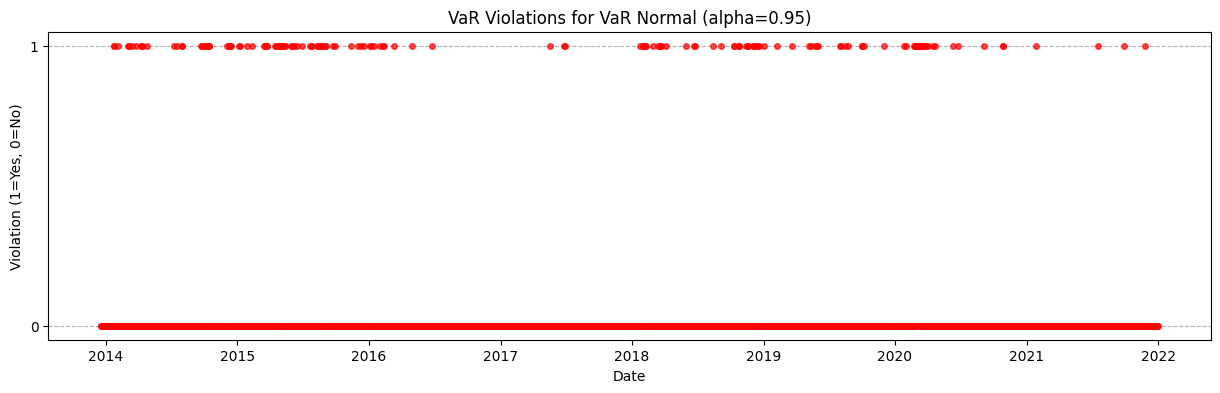


Confidence Level: 99.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.080000,8
2014,10,2.550000,255
2015,24,2.540000,254
2016,3,2.570000,257
2017,0,2.550000,255
2018,15,2.530000,253
2019,8,2.530000,253
2020,15,2.550000,255
2021,1,2.570000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,163809.676902,142557.074376,10
2015,269131.471101,219035.040296,24
2016,309092.416634,310446.980867,3
2018,248676.631424,219674.532586,15
2019,273539.465960,250898.015000,8
2020,612483.149846,349191.650073,15
2021,575601.043649,490903.378846,1


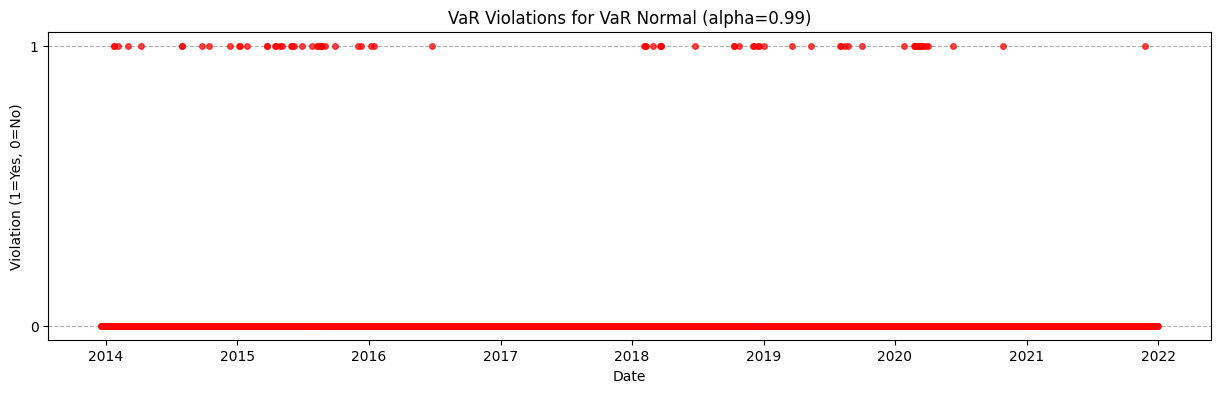


--- Backtesting for Model: VaR T3 ---

Confidence Level: 95.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.400000,8
2014,38,12.750000,255
2015,47,12.700000,254
2016,15,12.850000,257
2017,10,12.750000,255
2018,34,12.650000,253
2019,22,12.650000,253
2020,29,12.750000,255
2021,10,12.850000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,114189.458724,121541.753509,38
2015,210029.108798,186313.349699,47
2016,217712.441968,264131.937304,15
2017,166124.692362,230476.442979,10
2018,192421.411186,183427.583148,34
2019,203754.870363,210649.602812,22
2020,456403.409456,317179.345396,29
2021,320163.875320,411187.313141,10


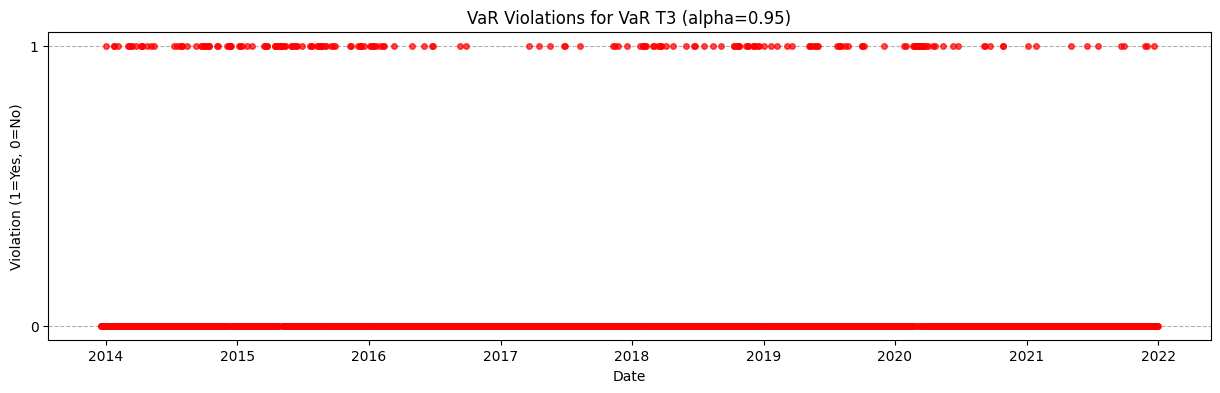


Confidence Level: 99.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.080000,8
2014,7,2.550000,255
2015,17,2.540000,254
2016,1,2.570000,257
2017,0,2.550000,255
2018,9,2.530000,253
2019,5,2.530000,253
2020,13,2.550000,255
2021,1,2.570000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,179775.771308,219689.882926,7
2015,297575.753560,337575.396936,17
2016,351547.263385,457831.696272,1
2018,278426.559684,329957.218177,9
2019,297005.528507,381554.389433,5
2020,641228.128594,505164.675263,13
2021,575601.043649,748608.602521,1


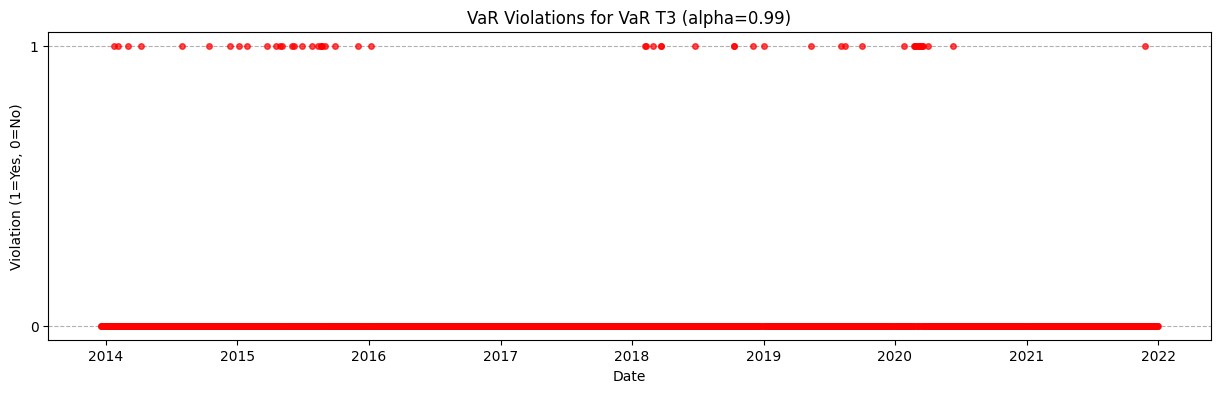


--- Backtesting for Model: VaR T4 ---

Confidence Level: 95.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.400000,8
2014,29,12.750000,255
2015,43,12.700000,254
2016,12,12.850000,257
2017,6,12.750000,255
2018,31,12.650000,253
2019,16,12.650000,253
2020,28,12.750000,255
2021,7,12.850000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,125831.124291,123015.471013,29
2015,218958.584982,189463.015611,43
2016,228935.702404,264442.474901,12
2017,189640.041405,244477.175087,6
2018,200130.751694,185715.978636,31
2019,231804.291914,214744.396263,16
2020,464847.994871,320046.943828,28
2021,343431.324190,415965.844787,7


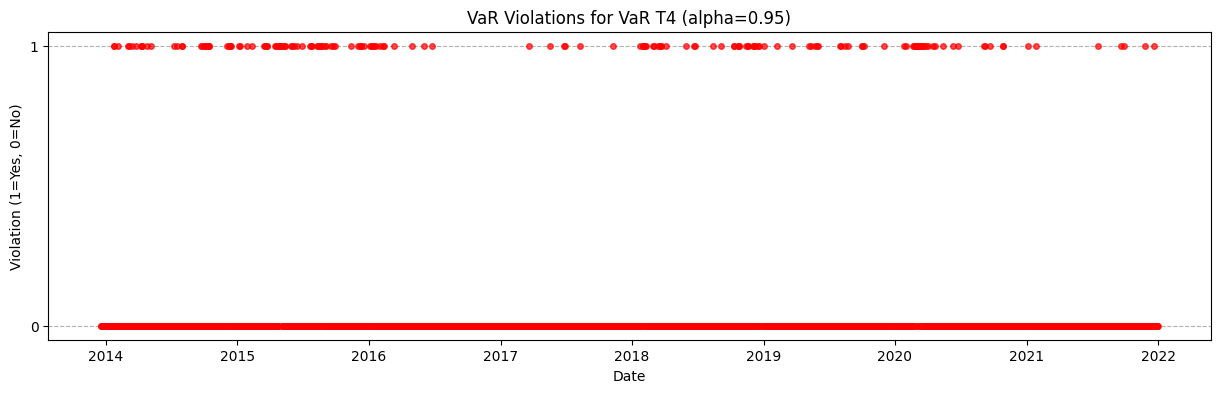


Confidence Level: 99.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.080000,8
2014,7,2.550000,255
2015,16,2.540000,254
2016,1,2.570000,257
2017,0,2.550000,255
2018,8,2.530000,253
2019,5,2.530000,253
2020,13,2.550000,255
2021,1,2.570000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,179775.771308,200254.155709,7
2015,299610.727486,303544.915114,16
2016,351547.263385,417705.580051,1
2018,286383.120191,300882.045620,8
2019,297005.528507,348209.190650,5
2020,641228.128594,461055.483554,13
2021,575601.043649,682832.719000,1


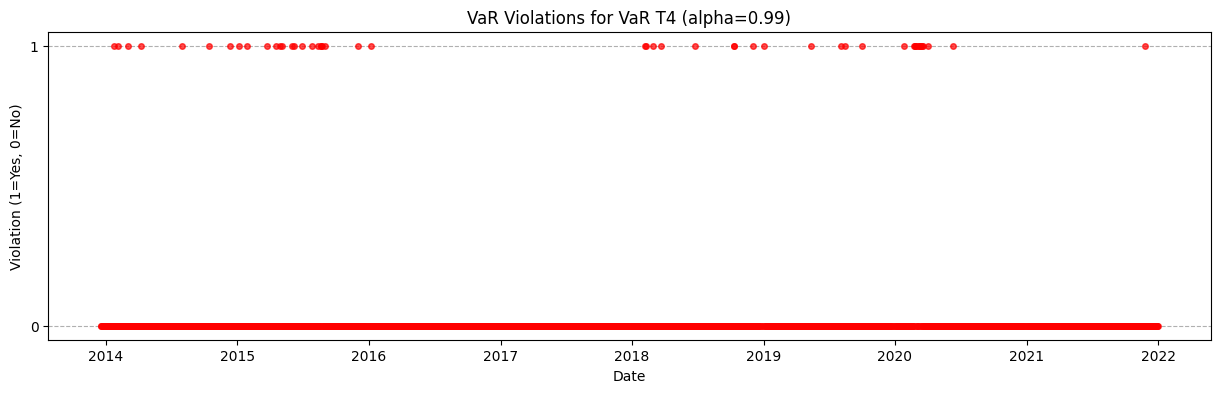


--- Backtesting for Model: VaR T5 ---

Confidence Level: 95.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.400000,8
2014,28,12.750000,255
2015,41,12.700000,254
2016,9,12.850000,257
2017,3,12.750000,255
2018,31,12.650000,253
2019,16,12.650000,253
2020,27,12.750000,255
2021,5,12.850000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,127474.408167,121630.687047,28
2015,221947.393729,184963.670083,41
2016,245764.990983,261394.268063,9
2017,220400.350367,248998.269538,3
2018,200130.751694,183533.793697,31
2019,231804.291914,212249.878179,16
2020,472195.479093,313766.848649,27
2021,369748.509129,412301.686223,5


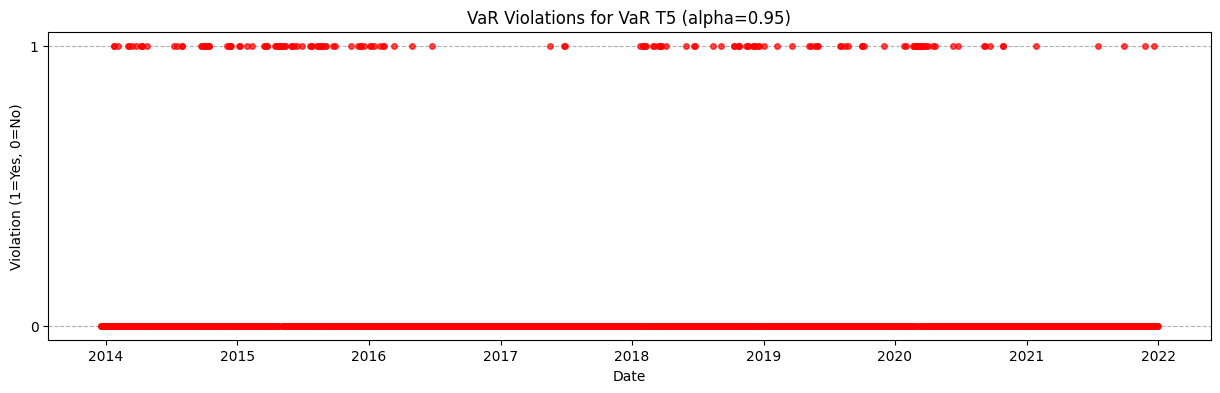


Confidence Level: 99.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.080000,8
2014,7,2.550000,255
2015,17,2.540000,254
2016,1,2.570000,257
2017,0,2.550000,255
2018,9,2.530000,253
2019,5,2.530000,253
2020,13,2.550000,255
2021,1,2.570000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,179775.771308,186844.257414,7
2015,297575.753560,287045.002808,17
2016,351547.263385,390020.115469,1
2018,278426.559684,280866.525295,9
2019,297005.528507,325202.296217,5
2020,641228.128594,430621.851301,13
2021,575601.043649,637449.909371,1


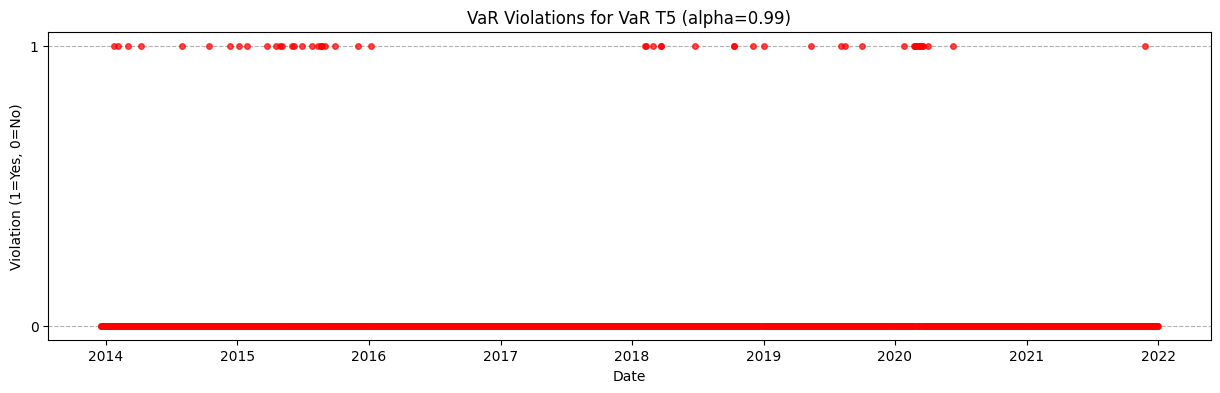


--- Backtesting for Model: VaR T6 ---

Confidence Level: 95.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.400000,8
2014,28,12.750000,255
2015,41,12.700000,254
2016,9,12.850000,257
2017,3,12.750000,255
2018,30,12.650000,253
2019,16,12.650000,253
2020,27,12.750000,255
2021,4,12.850000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,127474.408167,120208.412423,28
2015,221947.393729,182795.661153,41
2016,245764.990983,258398.723587,9
2017,220400.350367,246147.831828,3
2018,202672.175771,181565.241840,30
2019,231804.291914,209823.408649,16
2020,472195.479093,310190.169579,27
2021,388888.477055,405590.513707,4


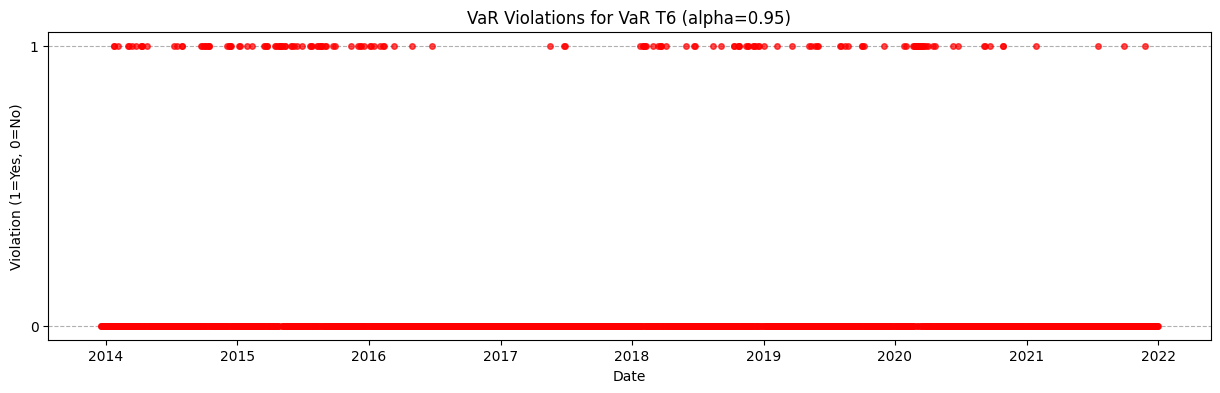


Confidence Level: 99.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.080000,8
2014,7,2.550000,255
2015,18,2.540000,254
2016,1,2.570000,257
2017,0,2.550000,255
2018,10,2.530000,253
2019,5,2.530000,253
2020,14,2.550000,255
2021,1,2.570000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,179775.771308,178207.740384,7
2015,293488.323760,274408.629581,18
2016,351547.263385,372189.556198,1
2018,270724.708198,267132.588001,10
2019,297005.528507,310384.925404,5
2020,629342.989524,424621.690161,14
2021,575601.043649,608221.543904,1


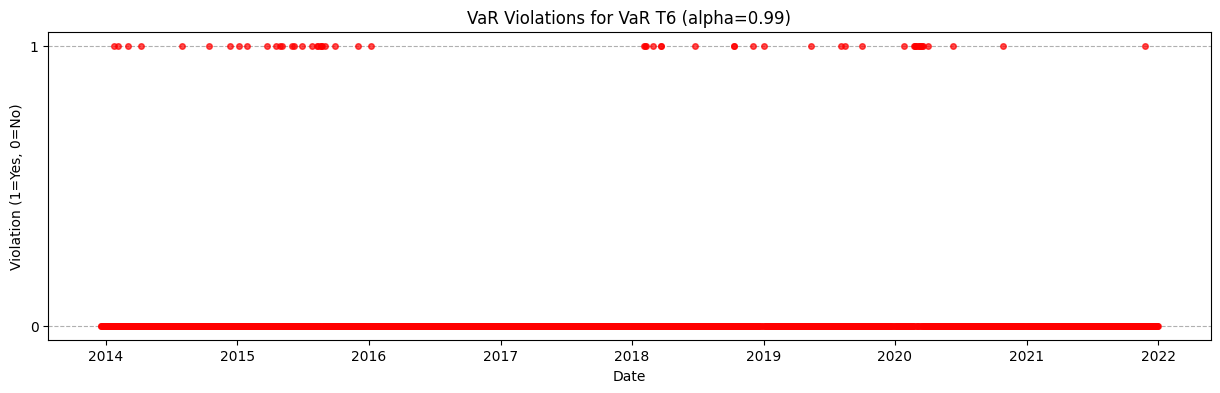


--- Backtesting for Model: VaR Historical ---

Confidence Level: 95.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.400000,8
2014,27,12.750000,255
2015,39,12.700000,254
2016,7,12.850000,257
2017,3,12.750000,255
2018,27,12.650000,253
2019,13,12.650000,253
2020,27,12.750000,255
2021,5,12.850000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,128777.472504,125501.570713,27
2015,227072.610375,196418.110345,39
2016,257968.727453,282523.750903,7
2017,220400.350367,275210.055835,3
2018,209631.045819,195629.125677,27
2019,244184.572209,236283.813979,13
2020,476939.641026,392817.014695,27
2021,369748.509129,506519.002402,5


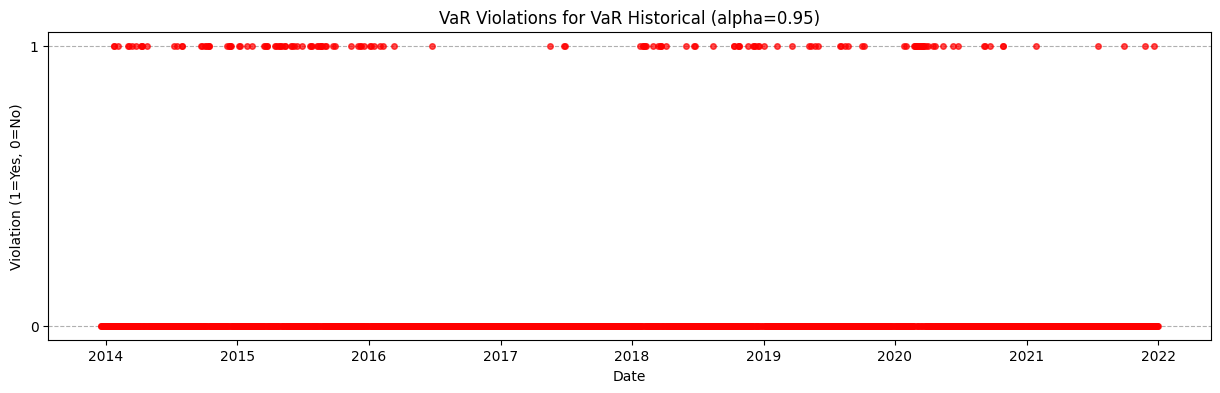


Confidence Level: 99.0%

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Total Observations
Year,,,
2013,0,0.080000,8
2014,7,2.550000,255
2015,14,2.540000,254
2016,1,2.570000,257
2017,0,2.550000,255
2018,8,2.530000,253
2019,5,2.530000,253
2020,10,2.550000,255
2021,0,2.570000,257



ES Backtest Summary (Yearly):


,Avg Actual Shortfall,Avg Predicted ES,Violation Count
Year,,,
2014,177716.097287,171450.125010,7
2015,312159.959315,275191.403957,14
2016,351547.263385,428332.321328,1
2018,286383.120191,270660.105791,8
2019,297005.528507,322629.706133,5
2020,722801.814214,573681.437772,10


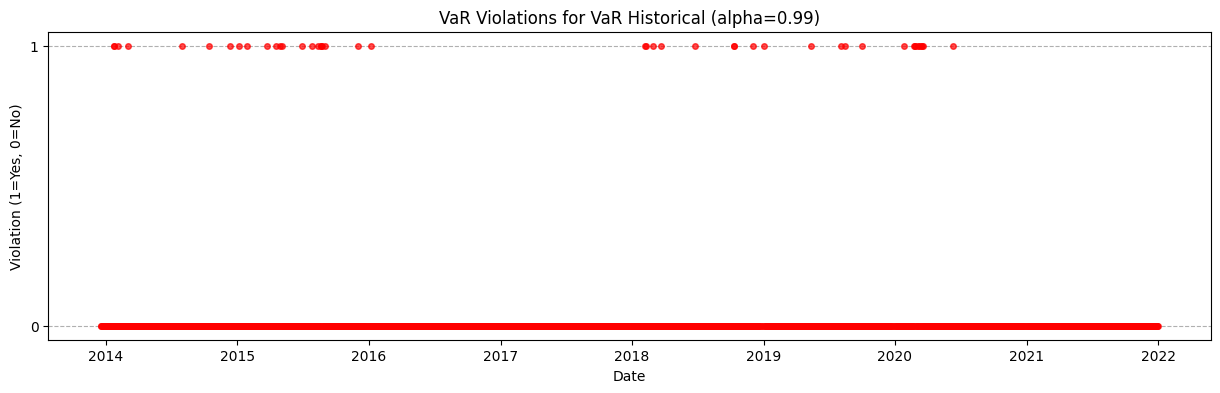

In [38]:
# Call the backtesting function with the required dataframes
run_backtesting(main_df, var_results_df, es_results_df)

### Backtesting Interpretation

Review the tables and plots above:

*   **VaR Backtest:** Compare 'Actual Violations' to 'Expected Violations' each year. Significant deviations might indicate issues with the VaR model's calibration. If actual violations consistently exceed expected, the model underestimates risk. If they are consistently lower, it might be too conservative.
*   **ES Backtest:** Compare 'Avg Actual Shortfall' to 'Avg Predicted ES'. If the actual average shortfall during violations is consistently higher than the predicted ES, the model underestimates the severity of tail losses.
*   **Violation Plots:** Look for patterns. Ideally, violations should be randomly distributed. Clustering of violations suggests the model fails to adapt quickly to changing market volatility (violation dependence).


# Stress Testing

For stress testing, different extreme changes are tested to measure their effect on the VaR and ES in the portfolio. We simulate these stresses by modifying the historical data over short, randomly selected periods and then re-evaluating the risk measures.

**Scenarios:**
1.  **Equity Stress:** Equity index returns changing by +/- 20% and +/- 40%.
2.  **Currency Stress:** USD/EUR and JPY/EUR exchange rates moving by +/- 10%.
3.  **Commodity Stress:** Interpreted as equity index returns changing by +/- 20% and +/- 40% (proxy for commodity impact).
4.  **Interest Rate Stress:** 10-year government bond yield shifting by +/- 2% and +/- 3% (absolute shift).

**Methodology:**
- Stresses are applied over randomly selected periods (max 4 consecutive days).
- Each scenario type (e.g., Equity +20%) is applied 5 times to different random periods.
- After applying stress to the underlying data, all dependent portfolio metrics (bond values, investment values, portfolio value, losses, returns) are recalculated.
- The VaR and ES calculations (using the previously defined `main` function) are re-run on the stressed dataset.
- Results are compared to the baseline (unstressed) VaR and ES.

In [39]:
def select_stress_periods(df, num_periods=5, max_duration=4, min_separation=20, data_start_offset=500):
    """Selects random start indices for stress periods."""
    potential_starts = list(range(data_start_offset, len(df) - max_duration))
    selected_indices = []
    attempts = 0
    max_attempts = num_periods * 10 # Prevent infinite loops
    
    while len(selected_indices) < num_periods and attempts < max_attempts:
        start_index = random.choice(potential_starts)
        duration = random.randint(1, max_duration)
        valid = True
        # Check for overlap/proximity with already selected periods
        for existing_start, existing_duration in selected_indices:
            if abs(start_index - existing_start) < min_separation:
                valid = False
                break
        if valid:
            selected_indices.append((start_index, duration))
        attempts += 1
        
    if len(selected_indices) < num_periods:
        print(f"Warning: Could only select {len(selected_indices)} out of {num_periods} stress periods.")
        
    return selected_indices

def recalculate_portfolio_metrics(df_stressed):
    """Recalculates all derived portfolio metrics after stressing base data."""
    df_recalc = df_stressed.copy()
    
    # --- Recalculate Bond Values (from cell 72b2903a) ---
    days_per_annum = 365
    interest_bond_initial = 1500000 # Initial investment in bond part of portfolio
    interest_bond_vector = np.zeros(len(df_recalc))
    interest_bond_profit_vector = np.zeros(len(df_recalc))
    interest_bond_loss_vector = np.zeros(len(df_recalc))
    daily_rates = np.zeros(len(df_recalc))
    
    if len(df_recalc) > 0:
        interest_bond_vector[0] = interest_bond_initial
        for i in range(len(df_recalc)):
            # Ensure the column name matches exactly
            yield_col_name = 'Yield curve spot rate, 10-year maturity - Government bond'
            if yield_col_name in df_recalc.columns:
                 # Adding 1.5% credit risk spread, converting to daily rate
                daily_rate = (((df_recalc[yield_col_name].iloc[i] + 1.5) / days_per_annum) * (7/5)) / 100
                daily_rates[i] = daily_rate
                if i > 0:
                    previous_value = interest_bond_vector[i-1]
                    current_value = previous_value * (1 + daily_rate)
                    interest_bond_vector[i] = current_value
                    change = current_value - previous_value
                    interest_bond_profit_vector[i] = change
                    interest_bond_loss_vector[i] = -change
                else: # First day calculation
                     daily_rate_first = (((df_recalc[yield_col_name].iloc[0] + 1.5) / days_per_annum) * (7/5)) / 100
                     daily_rates[0] = daily_rate_first
                     # No profit/loss on day 0
            else:
                print(f"Warning: Column '{yield_col_name}' not found during recalculation.")
                # Handle missing column case, e.g., set rates to 0 or raise error
                daily_rates[i] = 0
                if i > 0: interest_bond_vector[i] = interest_bond_vector[i-1]
                
        df_recalc['Interest_Bond'] = interest_bond_vector
        df_recalc['Interest_Bond_Profit'] = interest_bond_profit_vector
        df_recalc['Interest_Bond_Loss'] = interest_bond_loss_vector
        df_recalc['Interest_Bond_daily_rate'] = daily_rates
    
    # --- Recalculate Investment Values (from cell b7a319cf) ---
    # Assumes initial investment amounts are correctly set elsewhere or use the first row if available
    # Need starting amounts (re-run cell b203e94a logic conceptually)
    weights = {'S&P500': 0.4, 'DAX40': 0.3, 'NIKKEI': 0.15, 'EU-BOND': 0.15}
    starting_investment = 10000000
    starting_date = '2012-01-04'
    start_idx = df_recalc[df_recalc['Date'] == starting_date].index
    
    if not start_idx.empty:
        start_idx = start_idx[0]
        starting_row = df_recalc.loc[start_idx]
        usd_to_eur = float(starting_row['USD/EUR'])
        jpy_to_eur = float(starting_row['JPY/EUR'])
        invested_amount_SP500 = starting_investment * weights['S&P500'] / usd_to_eur
        invested_amount_DAX40 = starting_investment * weights['DAX40']
        invested_amount_NIKKEI = starting_investment * weights['NIKKEI'] / jpy_to_eur
        # EU Bond initial investment is implicitly handled by Interest_Bond starting value
        
        df_recalc.loc[start_idx, 'SP500_Investment'] = invested_amount_SP500
        df_recalc.loc[start_idx, 'DAX40_Investment'] = invested_amount_DAX40
        df_recalc.loc[start_idx, 'NIKKEI_Investment'] = invested_amount_NIKKEI
        # EU_BOND_Investment is directly from Interest_Bond
        
        for i in range(start_idx + 1, len(df_recalc)):
            df_recalc.loc[i, 'SP500_Investment'] = df_recalc.loc[i-1, 'SP500_Investment'] * (1 + df_recalc.loc[i, 'C_S&P500_Returns'])
            df_recalc.loc[i, 'DAX40_Investment'] = df_recalc.loc[i-1, 'DAX40_Investment'] * (1 + df_recalc.loc[i, 'C_Dax40_Returns'])
            df_recalc.loc[i, 'NIKKEI_Investment'] = df_recalc.loc[i-1, 'NIKKEI_Investment'] * (1 + df_recalc.loc[i, 'C_Nikkei_Returns'])
    
    # EU Bond investment is directly the calculated bond value
    df_recalc['EU_BOND_Investment'] = df_recalc['Interest_Bond']
    
    # --- Recalculate Portfolio Value/Change/Loss (from cell d340b392) ---
    df_recalc['Portfolio_Value_EUR'] = (
        df_recalc['SP500_Investment'].fillna(0) * df_recalc['USD/EUR'] +
        df_recalc['DAX40_Investment'].fillna(0) +
        df_recalc['NIKKEI_Investment'].fillna(0) * df_recalc['JPY/EUR'] +
        df_recalc['EU_BOND_Investment'].fillna(0)
    )
    # Reset first day value if necessary
    if not start_idx.empty:
         df_recalc.loc[start_idx, 'Portfolio_Value_EUR'] = starting_investment
         
    df_recalc['Portfolio_Change_EUR'] = df_recalc['Portfolio_Value_EUR'].diff()
    df_recalc['Portfolio_loss'] = -df_recalc['Portfolio_Change_EUR']
    # Set first day's change/loss to 0
    if not start_idx.empty:
        df_recalc.loc[start_idx, 'Portfolio_Change_EUR'] = 0.0
        df_recalc.loc[start_idx, 'Portfolio_loss'] = 0.0
    else: # If start date not found, set first row in df
        if len(df_recalc)>0:
            df_recalc.loc[0, 'Portfolio_Change_EUR'] = 0.0
            df_recalc.loc[0, 'Portfolio_loss'] = 0.0
            
    # --- Recalculate Portfolio Daily Returns (from cell 25566d3c) ---
    df_recalc['Portfolio_Daily_Returns'] = (
        weights['S&P500'] * df_recalc['C_S&P500_Returns'] +
        weights['DAX40'] * df_recalc['C_Dax40_Returns'] +
        weights['NIKKEI'] * df_recalc['C_Nikkei_Returns'] +
        weights['EU-BOND'] * df_recalc['Interest_Bond_daily_rate']
    ).fillna(0)
    
    return df_recalc

In [40]:
def stress_equity(df, periods, shock_factor):
    """Applies additive shock to equity returns during specified periods."""
    df_stressed = df.copy()
    equity_cols = ['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns']
    for start_index, duration in periods:
        for i in range(start_index, min(start_index + duration, len(df_stressed))):
            for col in equity_cols:
                # Apply additive shock: return' = return + shock
                df_stressed.loc[i, col] = df_stressed.loc[i, col] + shock_factor
    return df_stressed

def stress_currency(df, periods, shock_factor_major, shock_factor_other):
    """Applies multiplicative shock to currency rates during specified periods."""
    df_stressed = df.copy()
    # Assuming USD/EUR and JPY/EUR are major currencies
    major_cols = ['USD/EUR', 'JPY/EUR']
    # other_cols = [] # Add other currency columns if they exist
    
    for start_index, duration in periods:
        for i in range(start_index, min(start_index + duration, len(df_stressed))):
            for col in major_cols:
                # Apply multiplicative shock: rate' = rate * shock
                df_stressed.loc[i, col] = df_stressed.loc[i, col] * shock_factor_major
            # for col in other_cols:
            #     df_stressed.loc[i, col] = df_stressed.loc[i, col] * shock_factor_other
    return df_stressed

def stress_commodity(df, periods, shock_factor):
    """Applies additive shock to equity returns as a proxy for commodity stress."""
    # Reusing stress_equity logic as interpretation
    return stress_equity(df, periods, shock_factor)

def stress_interest_rate(df, periods, shock_shift):
    """Applies additive shift to interest rates during specified periods."""
    df_stressed = df.copy()
    rate_col = 'Yield curve spot rate, 10-year maturity - Government bond'
    for start_index, duration in periods:
        for i in range(start_index, min(start_index + duration, len(df_stressed))):
            # Apply additive shift: rate' = rate + shift
            # Ensure rate doesn't go below a reasonable floor if necessary (e.g., 0 or a small negative number)
            df_stressed.loc[i, rate_col] = max(-1.0, df_stressed.loc[i, rate_col] + shock_shift) # Example floor of -1%
            
    # IMPORTANT: Recalculate all dependent metrics after stressing interest rates
    df_stressed = recalculate_portfolio_metrics(df_stressed)
    return df_stressed

In [42]:
def run_stress_scenario(original_df, stress_type, shock_params, scenario_name):
    """Runs a single stress scenario and recalculates VaR/ES."""
    print(f"--- Running Stress Scenario: {scenario_name} ---")
    df_stressed = original_df.copy()
    
    # Select random periods for this specific scenario run
    periods = select_stress_periods(df_stressed, num_periods=shock_params.get('num_repeats', 5), 
                                    max_duration=shock_params.get('duration', 4))
    
    if stress_type == 'equity':
        df_stressed = stress_equity(df_stressed, periods, shock_params['shock'])
        df_stressed = recalculate_portfolio_metrics(df_stressed) # Recalc needed as returns changed
    elif stress_type == 'currency':
        df_stressed = stress_currency(df_stressed, periods, shock_params['shock_major'], shock_params.get('shock_other', 1.0))
        df_stressed = recalculate_portfolio_metrics(df_stressed) # Recalc needed as FX changed
    elif stress_type == 'commodity':
        df_stressed = stress_commodity(df_stressed, periods, shock_params['shock'])
        df_stressed = recalculate_portfolio_metrics(df_stressed) # Recalc needed as returns changed
    elif stress_type == 'interest_rate':
        # Recalculation is already handled within stress_interest_rate
        df_stressed = stress_interest_rate(df_stressed, periods, shock_params['shift'])
    else:
        raise ValueError(f"Unknown stress type: {stress_type}")
        
    # Re-run VaR/ES calculation using the existing main() function logic
    # Modify main() to accept a dataframe as input
    def main_modified(input_df):
        # Initialize lists to store results
        VaR_results = []
        ES_results = []
        # Define time window based on the input dataframe
        # Adjust date filtering if needed, ensure it aligns with how main() was used
        time_window = input_df[(input_df['Date'] >= '2012-01-05') & (input_df['Date'] <= '2021-12-31')].reset_index(drop=True)

        # Define confidence levels
        vAlpha = np.array([0.95, 0.99])
        
        # Define sample size and t-distribution degrees of freedom
        sample_size = 500
        degrees_of_freedom = [0, 3, 4, 5, 6]  # 0 represents normal distribution
        
        if len(time_window) <= sample_size:
             print(f"Warning: Not enough data ({len(time_window)}) for sample size {sample_size} in stressed scenario.")
             return pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
             
        for i in range(sample_size, len(time_window)):
            # Extract the rolling window
            window = time_window.iloc[i - sample_size:i]
            current_date = time_window.iloc[i]['Date']
            
            # Calculate loss statistics
            loss_stats = calculate_daily_loss_variables(window, current_date)
            mean_loss = loss_stats["Portfolio_mean_loss"]
            portfolio_std_loss = loss_stats["Portfolio_std_loss"]
            
            # Initialize result dictionaries for this date
            var_row = {'Date': current_date}
            es_row = {'Date': current_date}
            
            # Calculate VaR and ES using various distributions
            for df in degrees_of_freedom:
                results = calculate_var_cov(window, current_date, vAlpha, mean_loss, portfolio_std_loss, df)
                if df == 0: 
                    dist_label = "Normal" 
                else: dist_label = f"T{df}"
                
                var_row[f'VaR {dist_label}'] = results[f'VaR {dist_label}']
                es_row[f'ES {dist_label}'] = results[f'ES {dist_label}']
            
            # Calculate VaR and ES using historical simulation
            hist_results = calculate_historical_var_es(window, current_date, vAlpha)
            var_row['VaR Historical'] = hist_results['VaR Historical']
            es_row['ES Historical'] = hist_results['ES Historical']
            
            VaR_results.append(var_row)
            ES_results.append(es_row)

        # Convert results to DataFrame
        var_results_df = pd.DataFrame(VaR_results)
        es_results_df = pd.DataFrame(ES_results)
        
        # Multi-day VaR calculations might need adjustment or separate handling for stress tests
        # For simplicity, focusing on 1-day VaR/ES from the main loop
        # var_5d = calculate_multiday_var(vAlpha, 5, sample_size) # Needs df passed
        # var_10d = calculate_multiday_var(vAlpha, 10, sample_size) # Needs df passed
        var_5d, var_10d = pd.DataFrame(), pd.DataFrame() # Placeholder

        return var_results_df, es_results_df, var_5d, var_10d
        
    stressed_var, stressed_es, _, _ = main_modified(df_stressed)
    print(f"--- Finished Stress Scenario: {scenario_name} ---")
    return stressed_var, stressed_es

In [43]:
def stress_testing_main(original_df, baseline_var, baseline_es):
    """Defines and runs all stress test scenarios."""
    scenarios = {
        # Equity Stresses
        'Equity +20%': {'type': 'equity', 'params': {'shock': 0.20}},
        'Equity -20%': {'type': 'equity', 'params': {'shock': -0.20}},
        'Equity +40%': {'type': 'equity', 'params': {'shock': 0.40}},
        'Equity -40%': {'type': 'equity', 'params': {'shock': -0.40}},
        # Currency Stresses (Major +/- 10%)
        'Currency +10%': {'type': 'currency', 'params': {'shock_major': 1.10}},
        'Currency -10%': {'type': 'currency', 'params': {'shock_major': 0.90}},
        # Commodity Stresses (Proxy via Equity)
        'Commodity +20%': {'type': 'commodity', 'params': {'shock': 0.20}},
        'Commodity -20%': {'type': 'commodity', 'params': {'shock': -0.20}},
        'Commodity +40%': {'type': 'commodity', 'params': {'shock': 0.40}},
        'Commodity -40%': {'type': 'commodity', 'params': {'shock': -0.40}},
        # Interest Rate Stresses (Absolute Shift)
        'Interest Rate +2%': {'type': 'interest_rate', 'params': {'shift': 2.0}}, # Shift is in percentage points
        'Interest Rate -2%': {'type': 'interest_rate', 'params': {'shift': -2.0}},
        'Interest Rate +3%': {'type': 'interest_rate', 'params': {'shift': 3.0}},
        'Interest Rate -3%': {'type': 'interest_rate', 'params': {'shift': -3.0}},
    }
    
    results_summary = {}
    
    for name, config in scenarios.items():
        stressed_var, stressed_es = run_stress_scenario(original_df, config['type'], config['params'], name)
        
        # Compare stressed results to baseline (e.g., average VaR/ES)
        # Focus on Historical VaR/ES for comparison
        if not stressed_var.empty and not baseline_var.empty:
            avg_baseline_var_95 = np.mean([v[0] for v in baseline_var['VaR Historical']])
            avg_baseline_var_99 = np.mean([v[1] for v in baseline_var['VaR Historical']])
            avg_stressed_var_95 = np.mean([v[0] for v in stressed_var['VaR Historical']])
            avg_stressed_var_99 = np.mean([v[1] for v in stressed_var['VaR Historical']])
            
            avg_baseline_es_95 = np.mean([e[0] for e in baseline_es['ES Historical']])
            avg_baseline_es_99 = np.mean([e[1] for e in baseline_es['ES Historical']])
            avg_stressed_es_95 = np.mean([e[0] for e in stressed_es['ES Historical']])
            avg_stressed_es_99 = np.mean([e[1] for e in stressed_es['ES Historical']])
            
            results_summary[name] = {
                'Avg VaR 95% Change': avg_stressed_var_95 - avg_baseline_var_95,
                'Avg VaR 99% Change': avg_stressed_var_99 - avg_baseline_var_99,
                'Avg ES 95% Change': avg_stressed_es_95 - avg_baseline_es_95,
                'Avg ES 99% Change': avg_stressed_es_99 - avg_baseline_es_99,
                'Avg Stressed VaR 95%': avg_stressed_var_95,
                'Avg Stressed VaR 99%': avg_stressed_var_99,
                'Avg Stressed ES 95%': avg_stressed_es_95,
                'Avg Stressed ES 99%': avg_stressed_es_99
            }
        else:
             results_summary[name] = {'Error': 'Calculation failed or insufficient data'}
             
    return pd.DataFrame.from_dict(results_summary, orient='index')


In [44]:
results_summary = stress_testing_main(main_df, var_results_df, es_results_df)

--- Running Stress Scenario: Equity +20% ---


AttributeError: 'numpy.int64' object has no attribute 'empty'